This document explores whether we should use normalization (making data between 0 and 1) 
or standardization (making data have mean 0 and std 1) when preprocessing data

In [1]:
import torch, math
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import time

## Methods irrelevant to this notebook's focus

In [2]:
class Transformer(nn.Module):
    # d_model : number of features
    def __init__(self,feature_size=20,num_layers=3,dropout=0):
        super(Transformer, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=5, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)        
        # self.decoder = nn.Linear(feature_size,1)
        self.decoder = nn.Linear(feature_size,feature_size)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1    
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, src, device):
        mask = self._generate_square_subsequent_mask(len(src)).to(device)
        output = self.transformer_encoder(src,mask)
        output = self.decoder(output)
        return output
    

def train_transformer_teacher_forcing(EPOCH = 200):
    model = Transformer().double().to(device)
    model.train()  # turn on train mode
    
    model = Transformer().double().to(device)
    optimizer = torch.optim.Adam(model.parameters())
    criterion = torch.nn.MSELoss()
    best_model = ""
    min_train_loss = float('inf')
    
    for epoch in range(EPOCH + 1):
        train_loss = 0
        for i in range(theta_Tr.shape[0]):
            # iterate through each training example
            cur_theta = theta_Tr[i] # check dim later; not sure about batch
            optimizer.zero_grad()
            
            src = cur_theta[:-1,:] # input is the vector except for the last time step's
            src = torch.from_numpy(np.expand_dims(src, axis=1)).double() # torch.Size([59, 1, 20]) as 1 is batchsize
            target = cur_theta[1:,:] # this is the ground truth output, shift by one according to Medium blog post
            target = torch.from_numpy(np.expand_dims(target, axis=1)).double() # torch.Size([59, 1, 20])
            
            prediction = model(src, device)
            loss = criterion(prediction, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.detach().item()
            
        if train_loss < min_train_loss:
            torch.save(model.state_dict(), path_to_save_model + f"best_train.pth")
            torch.save(optimizer.state_dict(), path_to_save_model + f"optimizer.pth")
            min_train_loss = train_loss
            
        if epoch % (np.ceil(EPOCH / 10)) == 0:
            print(f"Epoch: {epoch}, Average training loss: {train_loss / theta_Tr.shape[0]}")

def inference_cheat():
    """
    We call it cheat because the Transformer is not supposed to know any other input
    except for the initial condition (i.e. the t0 state)
    """ 
    model = Transformer().double().to(device)
    model.load_state_dict(torch.load(path_to_save_model+"best_train.pth"))
    criterion = torch.nn.MSELoss()
    
    total_loss = 0
    
    # loss_dict records the loss for each test, for visualization purpose 
    loss_dict = np.zeros(theta_Te.shape[0])
    
    with torch.no_grad():
        for i in range(theta_Te.shape[0]):
            cur_theta = theta_Te[i]
            src = cur_theta[:-1,:] # t0 to 58 # THE CHEATING PART
            src = torch.from_numpy(np.expand_dims(src, axis=1)).double() # torch.Size([59, 1, 20]) as 1 is batchsize
            target = cur_theta[1:,:] # shift by one according to Medium # t1 to 59
            target = torch.from_numpy(np.expand_dims(target, axis=1)).double()
            
            prediction = model(src, device) # t1 to 59
            cur_loss = criterion(prediction, target).item()
            total_loss += cur_loss
            
            loss_dict[i] = cur_loss
             
    return total_loss / theta_Te.shape[0], loss_dict


def inference_one_input():
    """
    As opposed to the cheating version of inference, the Transformer will only know about the t0 for input;
    then each time the transformer predicts the next timestamp, this output is recycled to be the input
    for the next timestamp's input.
    """ 
    model = Transformer().double().to(device)
    model.load_state_dict(torch.load(path_to_save_model+"best_train.pth"))
    criterion = torch.nn.MSELoss()
    
    total_loss = 0
    
    # worst is used to visualize the worst prediction
    worst_dict = {"id": -1, 
                 "loss": -1, 
                 "pred": np.zeros(1)}
    
    with torch.no_grad():
        for i in range(theta_Te.shape[0]):
            cur_theta = theta_Te[i]
            src = cur_theta[0,:] # t0
            src = torch.from_numpy(np.expand_dims(src, axis=[0,1])).double() # torch.Size([1, 1, 20]) as 1 is batchsize
            
            target = cur_theta[1:,:] # shift by one according to Medium # t1 to 59
            target = torch.from_numpy(np.expand_dims(target, axis=1)).double()
            
            all_predictions = []
            next_input_model = src
            
            for j in range(59): # iterate through the entire forecast window
                prediction = model(next_input_model, device) # torch.Size([j, 1, 20])
                
                if all_predictions == []:
                    all_predictions = prediction # 1, 1, 20
                else:
                    all_predictions = torch.cat((all_predictions, prediction[-1,:,:].unsqueeze(0)))
                    
                next_input_model = all_predictions
            
            cur_loss = criterion(all_predictions, target).item()
            total_loss += cur_loss

            if cur_loss > worst_dict["loss"]:
                worst_dict["loss"] = cur_loss
                worst_dict["id"] = i
                worst_dict["pred"] = prediction
             
    return total_loss / theta_Te.shape[0], worst_dict


def visualize_test(loss_array, average_testing_loss, want_worst = False, want_avg = False):
    """
    If want worst, will plot the test with the highest loss
    If want avg, will plot the test with the loss closest to the average
    """
    assert (want_worst + want_avg) == 1 # can only visualize one
    
    # 1. first locate the id that we want to visualize
    viz_id = -1
    if want_worst:
        viz_id = np.argmax(loss_array)
    elif want_avg:
        viz_id = np.argmin(np.abs(loss_array - average_testing_loss))
        
    # 2. rerun model for this test
    model = Transformer().double().to(device)
    model.load_state_dict(torch.load(path_to_save_model+"best_train.pth"))
    criterion = torch.nn.MSELoss()
    
    prediction = np.zeros(1)
    cur_loss = 0
    target = np.zeros(1)
    
    with torch.no_grad():
        cur_theta = theta_Te[viz_id]
        src = cur_theta[:-1,:] # t0 to 58 # THE CHEATING PART
        src = torch.from_numpy(np.expand_dims(src, axis=1)).double() # torch.Size([59, 1, 20]) as 1 is batchsize
        target = cur_theta[1:,:] # shift by one according to Medium # t1 to 59
        target = torch.from_numpy(np.expand_dims(target, axis=1)).double()
        prediction = model(src, device) # t1 to 59
        cur_loss = criterion(prediction, target).item()
        
    print("Visualizing test with loss: " + str(cur_loss))
    target = theta_Te[viz_id, 1:]
    prediction = torch.squeeze(prediction)
    
    # 3. first plot position
    fig, axs = plt.subplots(nrows = 5, ncols = 2, figsize = [10,8], dpi = 200, sharex=True, sharey=True)
    for i_loop in range(10):
        i = i_loop * 2 # since we only want the position features
        plt.sca(axs.flatten()[i_loop])
        plt.plot(target[:,i], '.-', lw = 1, c = 'k', alpha = 0.5, label = 'ground truth')
        plt.plot(prediction[:,i], '.-', lw = 1, c = 'b', alpha = 0.5, label = 'NN prediction')
        plt.xlabel('Timestep')
        plt.ylabel('Position')
        plt.title(f'Pendulum {i_loop}')
        plt.grid()
    fig.suptitle("Position Comparison")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # 4. then plot velocity
    fig, axs = plt.subplots(nrows = 5, ncols = 2, figsize = [10,8], dpi = 100, sharex=True, sharey=True)
    for i_loop in range(10):
        i = i_loop * 2 + 1 # since we only want the velocity features
        plt.sca(axs.flatten()[i_loop])
        plt.plot(target[:,i], '.-', lw = 1, c = 'k', alpha = 0.5, label = 'ground truth')
        plt.plot(prediction[:,i], '.-', lw = 1, c = 'b', alpha = 0.5, label = 'NN prediction')
        plt.xlabel('Timestep')
        plt.ylabel('Velocity')
        plt.title(f'Pendulum {i_loop}')
        plt.grid()
    fig.suptitle("Velocity Comparison")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    
def visualize_worst_test(worst_dict):
    # 1. first plot position
    target_D = theta_Te[worst_dict["id"], 1:] # 59 x 20, target for each timestamp, each feature
    pred_D = torch.squeeze(worst_dict["pred"]) # 59 x 20, a prediction for each timestamp, each feature
    fig, axs = plt.subplots(nrows = 5, ncols = 2, figsize = [10,8], dpi = 200, sharex=True, sharey=True)
    for i_loop in range(10):
        i = i_loop * 2 # since we only want the position features
        plt.sca(axs.flatten()[i_loop])
        plt.plot(target_D[:,i], '.-', lw = 1, c = 'k', alpha = 0.5, label = 'ground truth')
        plt.plot(pred_D[:,i], '.-', lw = 1, c = 'b', alpha = 0.5, label = 'NN prediction')
        plt.xlabel('Timestep')
        plt.ylabel('Position')
        plt.title(f'Pendulum {i_loop}')
        plt.grid()
    fig.suptitle("Position Comparison")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # 2. then plot velocity
    target_D = theta_Te[worst_dict["id"], 1:] # 59 x 20, target for each timestamp, each feature
    pred_D = torch.squeeze(worst_dict["pred"]) # 59 x 20, a prediction for each timestamp, each feature
    fig, axs = plt.subplots(nrows = 5, ncols = 2, figsize = [10,8], dpi = 100, sharex=True, sharey=True)
    for i_loop in range(10):
        i = i_loop * 2 + 1 # since we only want the velocity features
        plt.sca(axs.flatten()[i_loop])
        plt.plot(target_D[:,i], '.-', lw = 1, c = 'k', alpha = 0.5, label = 'ground truth')
        plt.plot(pred_D[:,i], '.-', lw = 1, c = 'b', alpha = 0.5, label = 'NN prediction')
        plt.xlabel('Timestep')
        plt.ylabel('Velocity')
        plt.title(f'Pendulum {i_loop}')
        plt.grid()
    fig.suptitle("Velocity Comparison")
    plt.legend()
    plt.tight_layout()
    plt.show()

## Initial Test and Visualization on One Data

In [3]:
theta_Tr = np.zeros(1)
theta_Te = np.zeros(1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
path_to_save_model = 'normal_standard_save_model/'

def preproceess_data(NUM_DATA, sanity_check = False):
    global theta_Tr, theta_Te
    # 1. Load the data from npz file
    if not sanity_check:
        data = np.load('10pendula.npz')
    else:
        data = np.load('10pendula_sanity_check.npz')
    for key, val in data.items():
        exec(key + '=val')
    og_theta = data['theta']
    # below prints the evolution of the position (angle) over time of the 2nd pendulum in the 121st sample
    # plt.plot(og_theta[:, 111, 3, 0])
    
    # 2. preproceses data to the dimension we want
    # now, there are NUM_DATA data entry (i.e. initial conditions), 
    # each has 60 timesteps, and each timestep is a vector of size 20 
    # each feature: [p0, v0, p1, v1, ... p19, v19]
    theta = np.transpose(og_theta, (1, 0, 2, 3)).reshape(50000, 60, 20)
    theta = theta[:NUM_DATA, :, :]
    N, _, _ = theta.shape
    cutoff = int(np.ceil(0.7 * N))
    theta_Tr = theta[:cutoff, :, :]
    theta_Te = theta[cutoff: , :, :]

In [4]:
preproceess_data(NUM_DATA=800, sanity_check = False)

pos_tr = theta_Tr[:,:,::2]
vel_tr = theta_Tr[:,:,1::2]

min_pos = np.min(pos_tr)
max_pos = np.max(pos_tr)
min_vel = np.min(vel_tr)
max_vel = np.max(vel_tr)

mean_pos = np.mean(pos_tr)
std_pos = np.std(pos_tr)
mean_vel = np.mean(vel_tr)
std_vel = np.std(vel_tr)

print("max_pos: {}".format(min_pos))
print("min_pos: {}".format(max_pos))
print("max_vel: {}".format(min_vel))
print("min_vel: {}".format(max_vel))

print("mean_pos: {}".format(mean_pos))
print("std_pos: {}".format(std_pos))
print("mean_vel: {}".format(mean_vel))
print("std_vel: {}".format(std_vel))

max_pos: -2.4729630947113037
min_pos: 2.279109001159668
max_vel: -21.591453552246094
min_vel: 20.669544219970703
mean_pos: 0.0004919036873616278
std_pos: 0.6465010643005371
mean_vel: 0.003174335230141878
std_vel: 6.525984287261963


### First standardize one training data to see the effect; then visualize the standardized data, compare with the og_data to see if shape is preserved

In [5]:
og_x = theta_Tr[0] # use first data for an example
standardized_x = og_x.copy()

standardized_x[:,::2] = (og_x[:,::2] - mean_pos) / std_pos # standardize pos
standardized_x[:,1::2] = (og_x[:,1::2] - mean_vel) / std_vel # standardize velocity

print("new mean is {}".format(np.mean(standardized_x)))
print("New std is {}".format(np.std(standardized_x)))

# convert back
back_x = standardized_x.copy()
back_x[:,::2] = standardized_x[:,::2] * std_pos + mean_pos # standardize pos
back_x[:,1::2] = standardized_x[:,1::2] * std_vel + mean_vel # standardize velocity
print(np.max(back_x - og_x))

new mean is 0.0030712985899299383
New std is 0.8546732664108276
4.7683716e-07


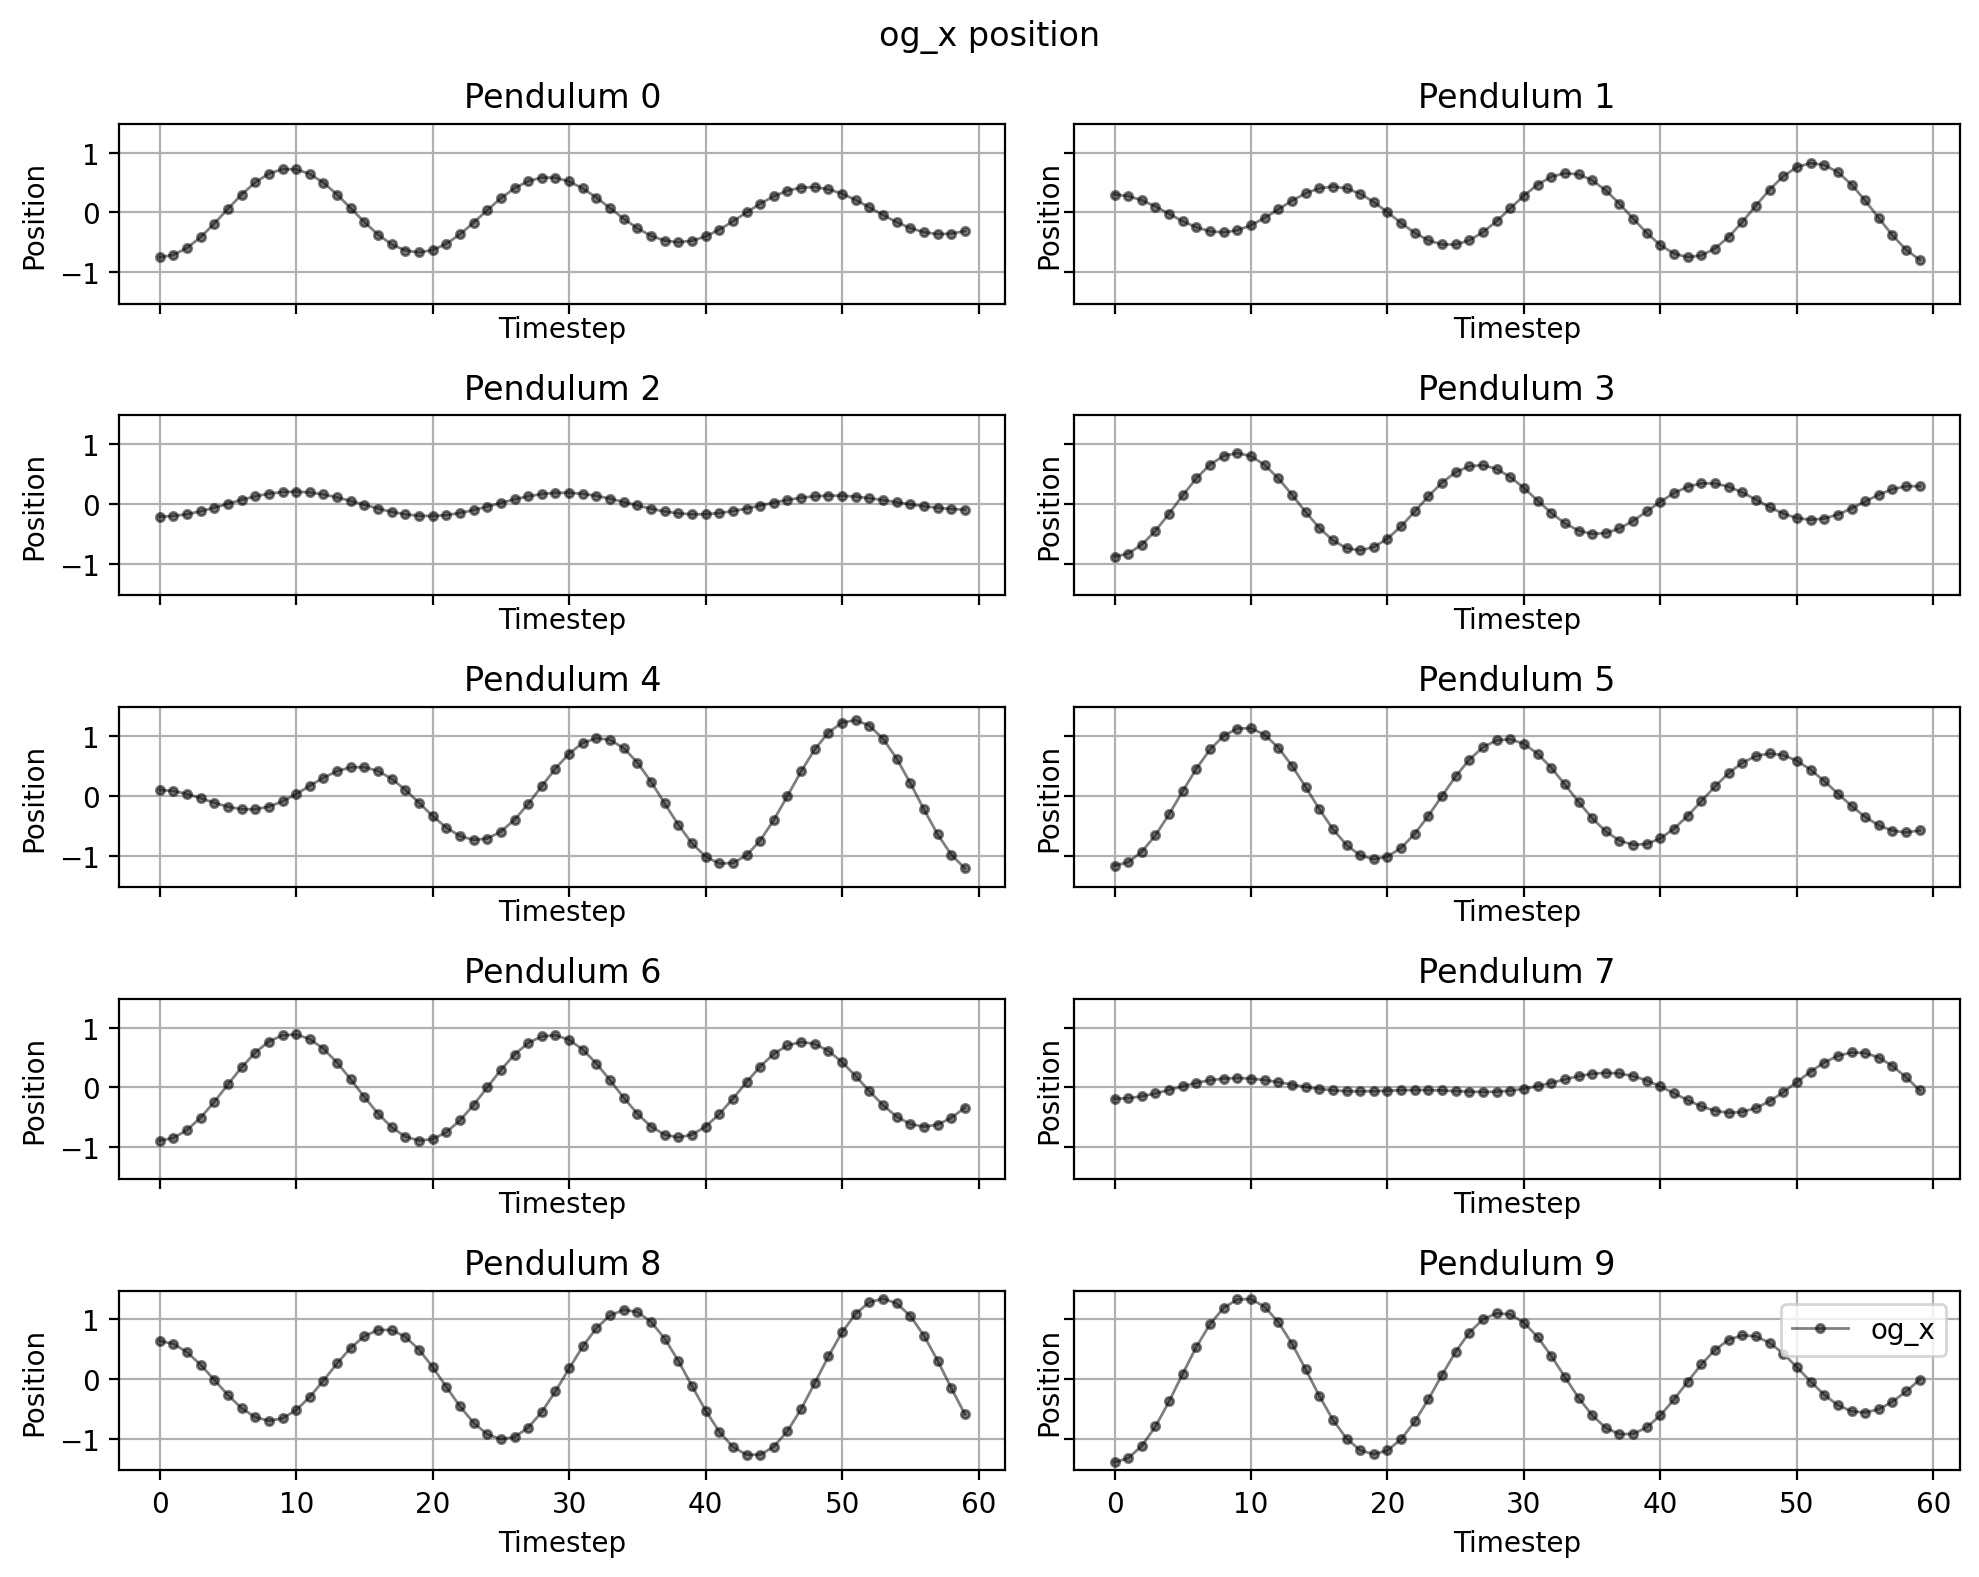

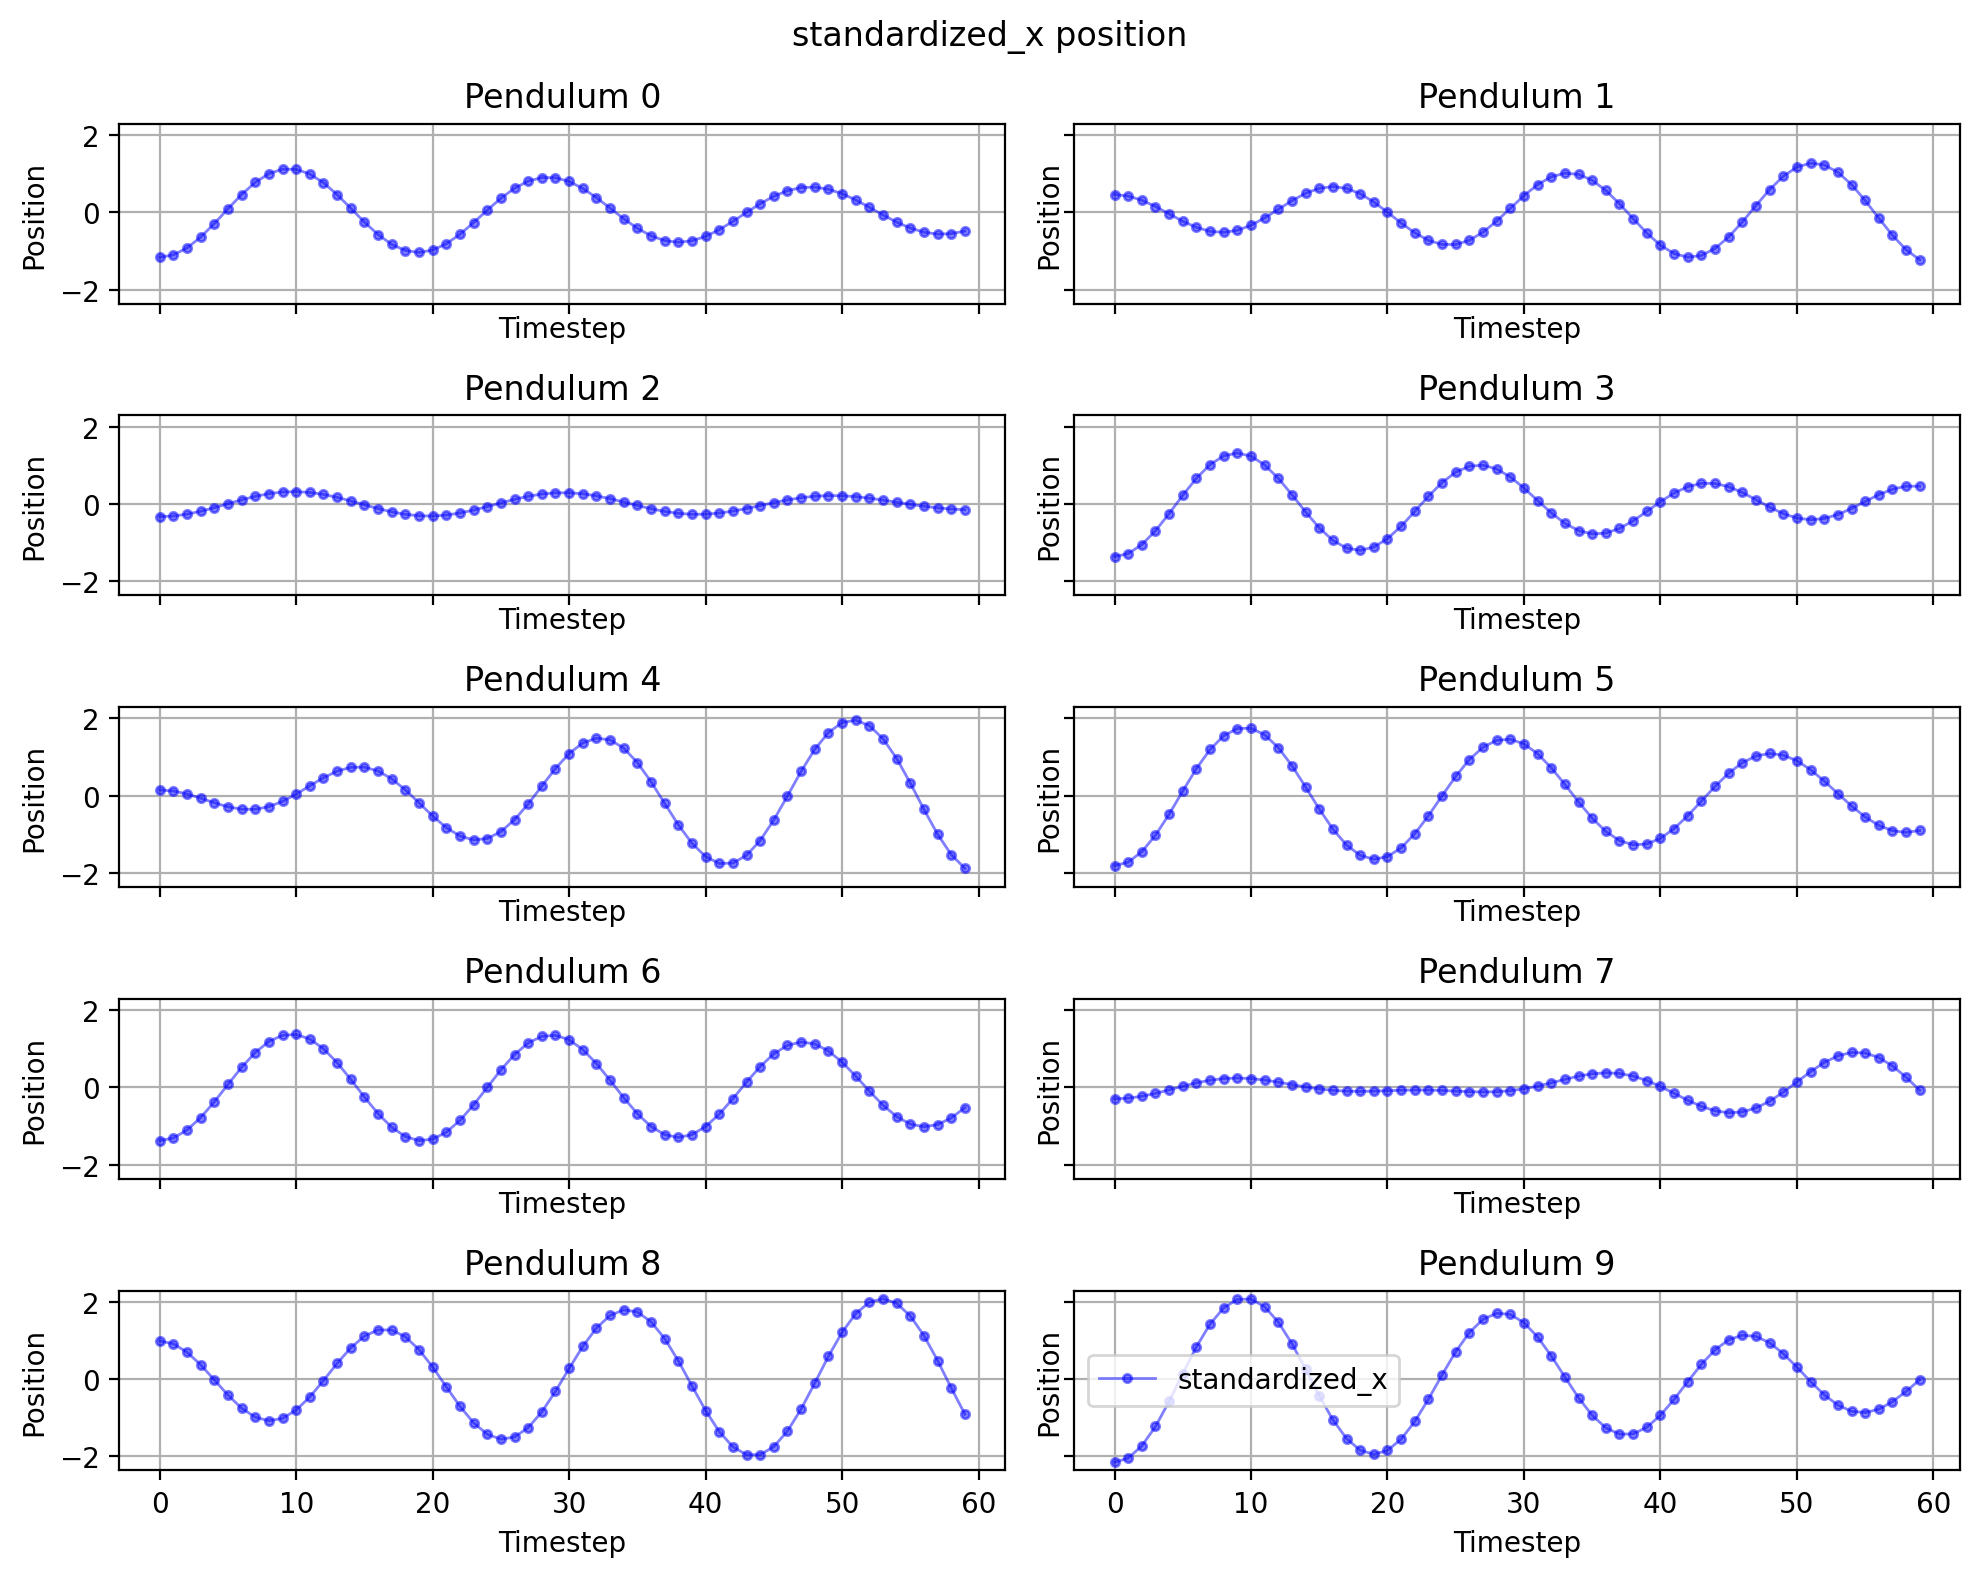

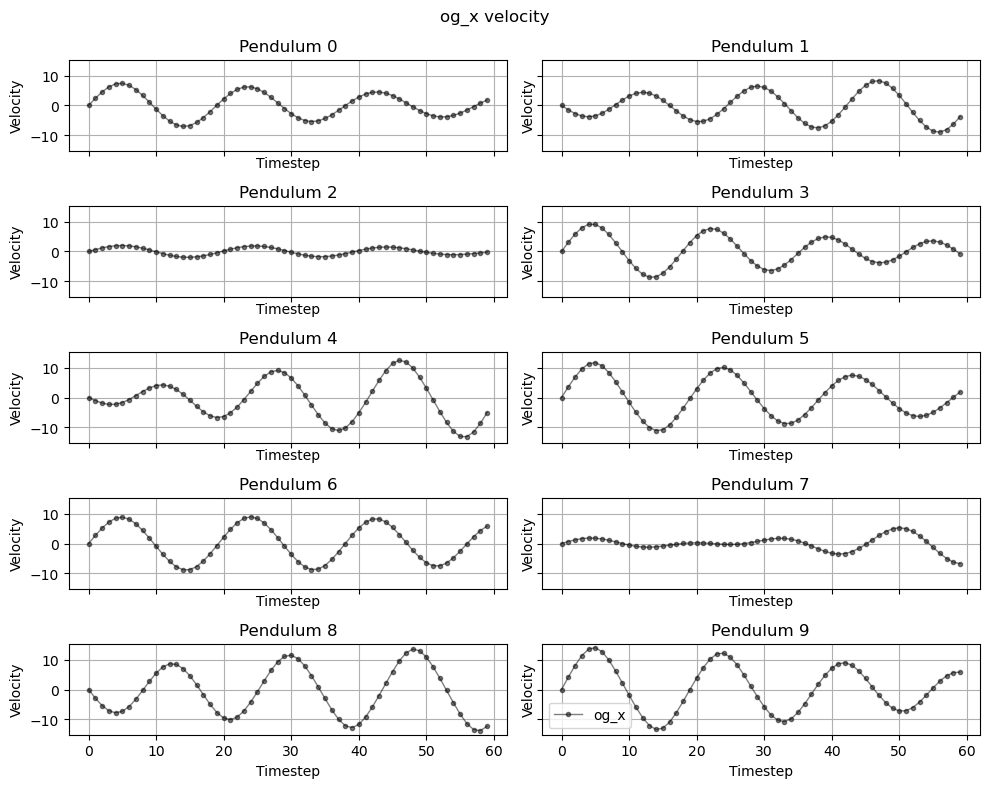

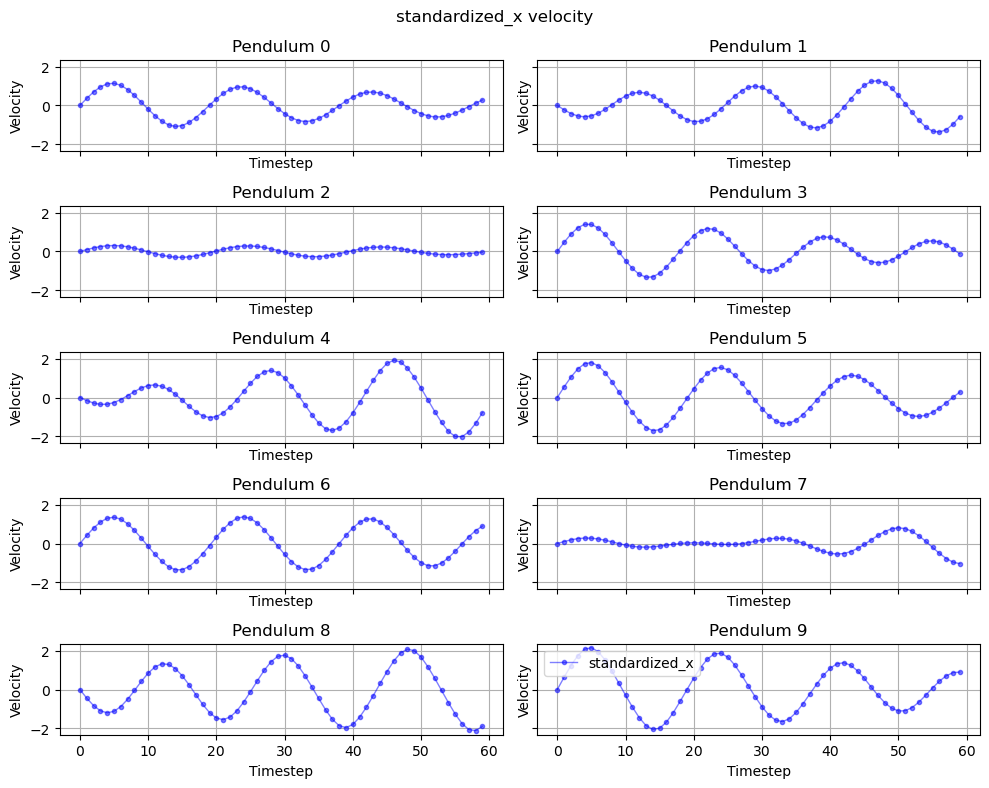

In [6]:
# 1. plot og_x position
fig, axs = plt.subplots(nrows = 5, ncols = 2, figsize = [10,8], dpi = 200, sharex=True, sharey=True)
for i_loop in range(10):
    i = i_loop * 2 # since we only want the position features
    plt.sca(axs.flatten()[i_loop])
    plt.plot(og_x[:,i], '.-', lw = 1, c = 'k', alpha = 0.5, label = 'og_x')
    plt.xlabel('Timestep')
    plt.ylabel('Position')
    plt.title(f'Pendulum {i_loop}')
    plt.grid()
fig.suptitle("og_x position")
plt.legend()
plt.tight_layout()
plt.show()

# 2. plot standardized_x position
fig, axs = plt.subplots(nrows = 5, ncols = 2, figsize = [10,8], dpi = 200, sharex=True, sharey=True)
for i_loop in range(10):
    i = i_loop * 2 # since we only want the position features
    plt.sca(axs.flatten()[i_loop])
    plt.plot(standardized_x[:,i], '.-', lw = 1, c = 'b', alpha = 0.5, label = 'standardized_x')
    plt.xlabel('Timestep')
    plt.ylabel('Position')
    plt.title(f'Pendulum {i_loop}')
    plt.grid()
fig.suptitle("standardized_x position")
plt.legend()
plt.tight_layout()
plt.show()

# 3. plot og_x velocity
fig, axs = plt.subplots(nrows = 5, ncols = 2, figsize = [10,8], dpi = 100, sharex=True, sharey=True)
for i_loop in range(10):
    i = i_loop * 2 + 1 # since we only want the velocity features
    plt.sca(axs.flatten()[i_loop])
    plt.plot(og_x[:,i], '.-', lw = 1, c = 'k', alpha = 0.5, label = 'og_x')
    plt.xlabel('Timestep')
    plt.ylabel('Velocity')
    plt.title(f'Pendulum {i_loop}')
    plt.grid()
fig.suptitle("og_x velocity")
plt.legend()
plt.tight_layout()
plt.show()

# 4. plot standardized_x velocity
fig, axs = plt.subplots(nrows = 5, ncols = 2, figsize = [10,8], dpi = 100, sharex=True, sharey=True)
for i_loop in range(10):
    i = i_loop * 2 + 1 # since we only want the velocity features
    plt.sca(axs.flatten()[i_loop])
    plt.plot(standardized_x[:,i], '.-', lw = 1, c = 'b', alpha = 0.5, label = 'standardized_x')
    plt.xlabel('Timestep')
    plt.ylabel('Velocity')
    plt.title(f'Pendulum {i_loop}')
    plt.grid()
fig.suptitle("standardized_x velocity")
plt.legend()
plt.tight_layout()
plt.show()

### Then do the same thing for normalization

In [7]:
og_x = theta_Tr[0] # use first data for an example
normalized_x = og_x.copy()

normalized_x[:,::2] = (og_x[:,::2] - min_pos) / (max_pos - min_pos) # normalize pos
normalized_x[:,1::2] = (og_x[:,1::2] - min_vel) / (max_vel - min_vel) # normalize velocity

print("new max is {}".format(np.max(normalized_x)))
print("New min is {}".format(np.min(normalized_x)))

# convert back
back_x = normalized_x.copy()
back_x[:,::2] = normalized_x[:,::2] * (max_pos - min_pos) + min_pos # standardize pos
back_x[:,1::2] = normalized_x[:,1::2] * (max_vel - min_vel) + min_vel # standardize velocity
print(np.max(back_x - og_x))

new max is 0.8426041007041931
New min is 0.18528781831264496
2.861023e-06


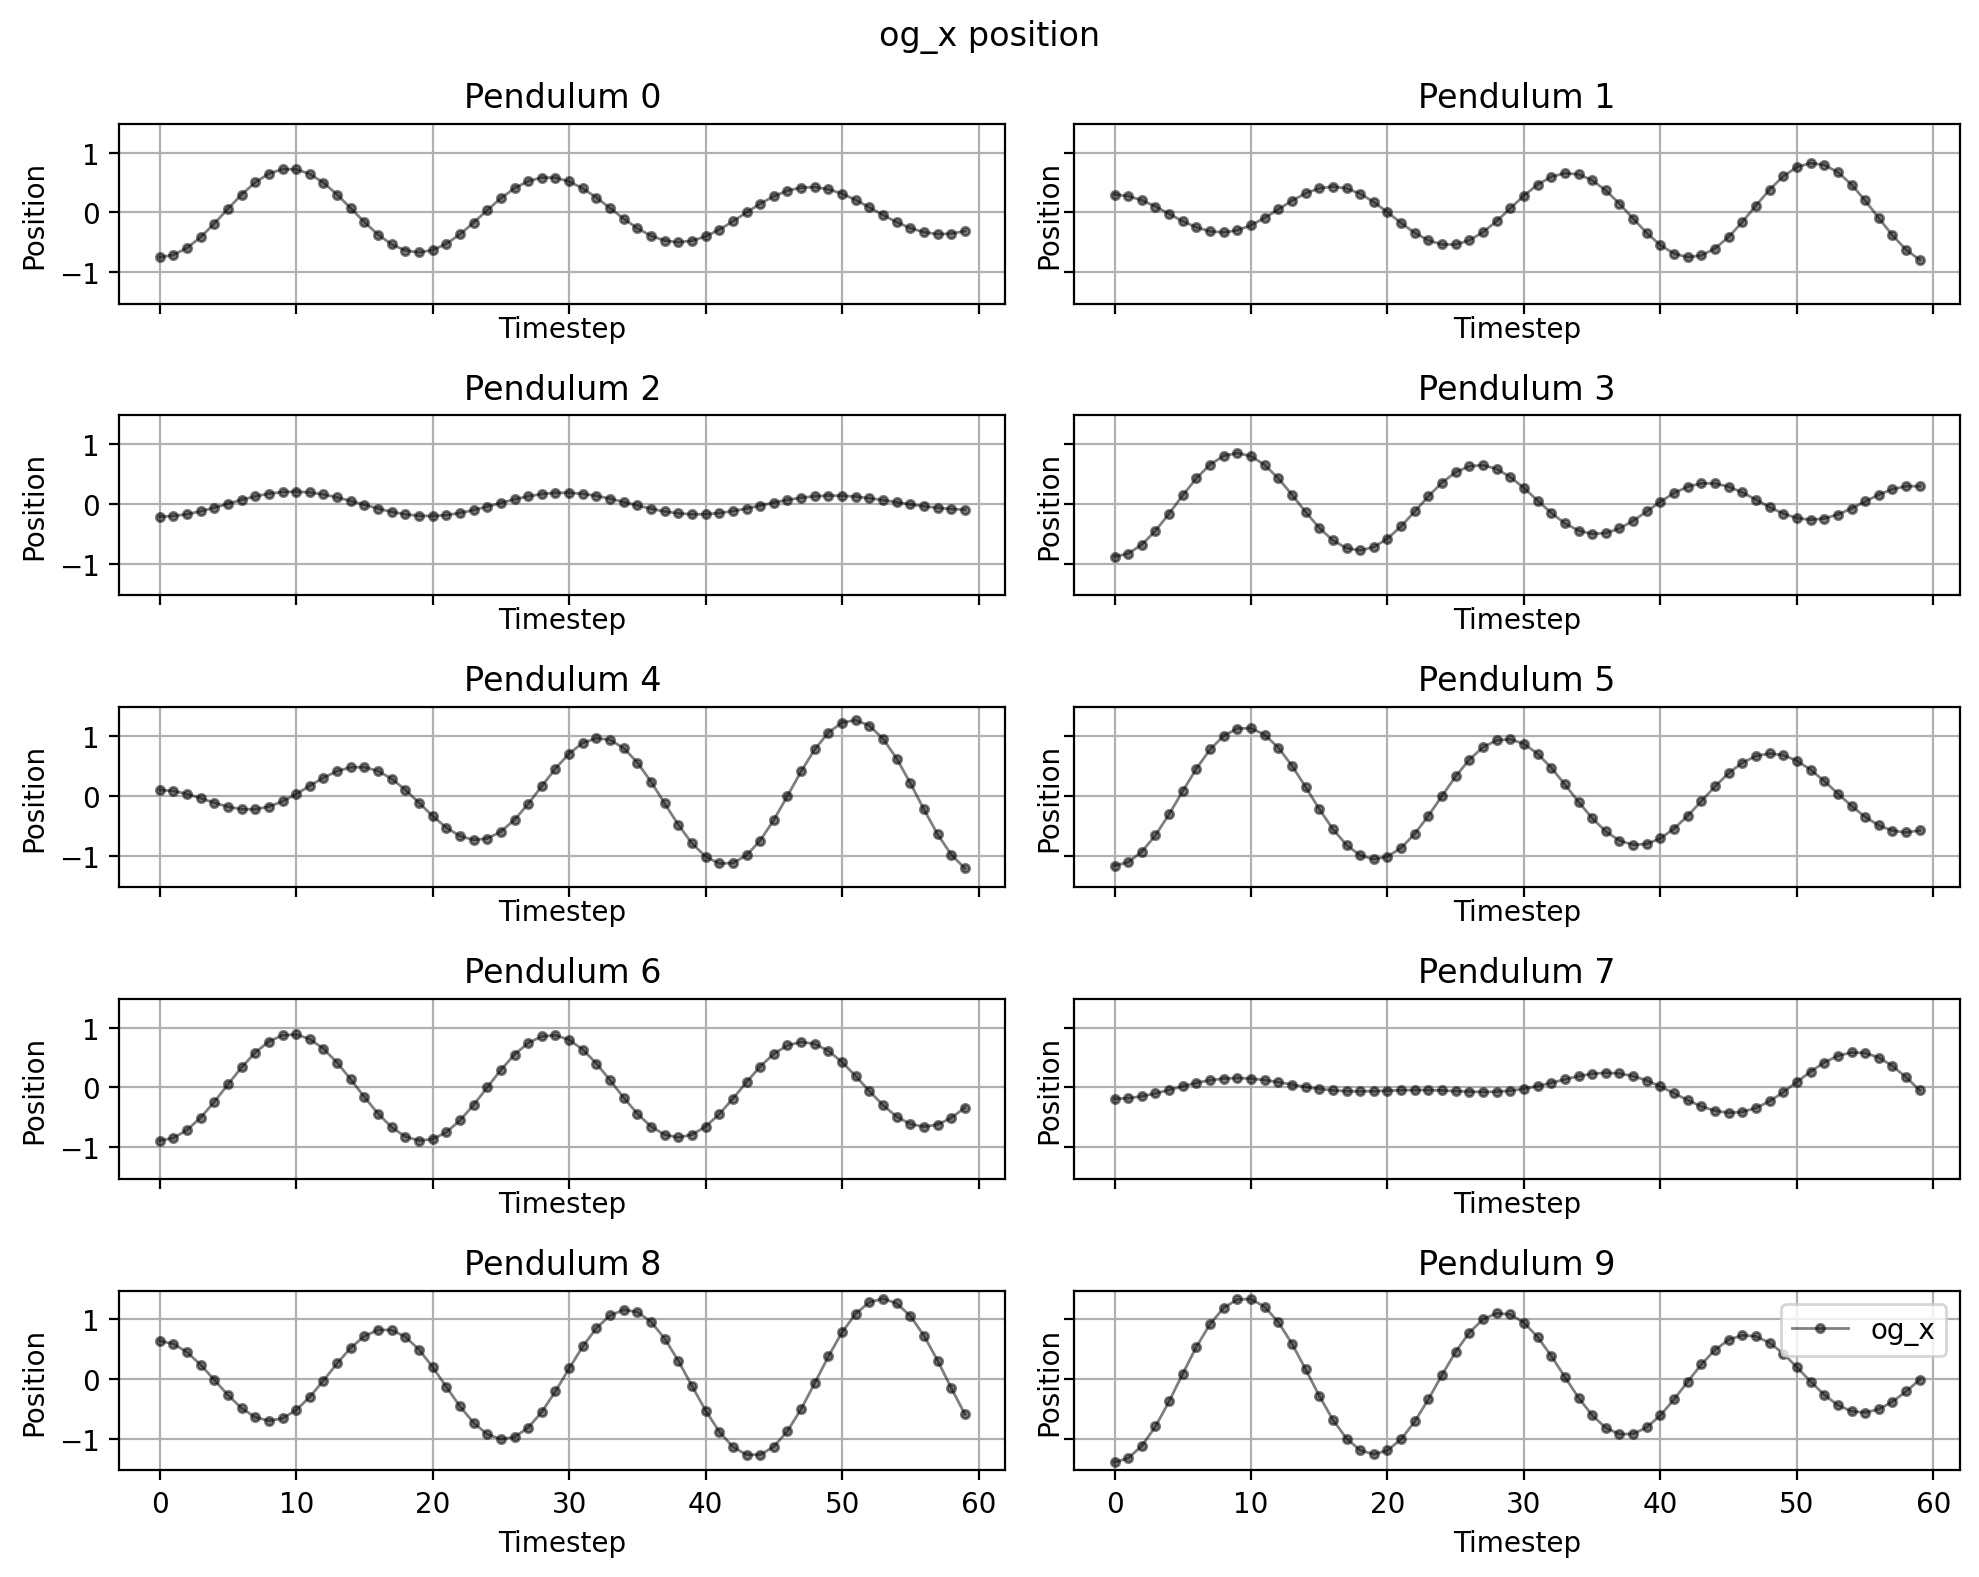

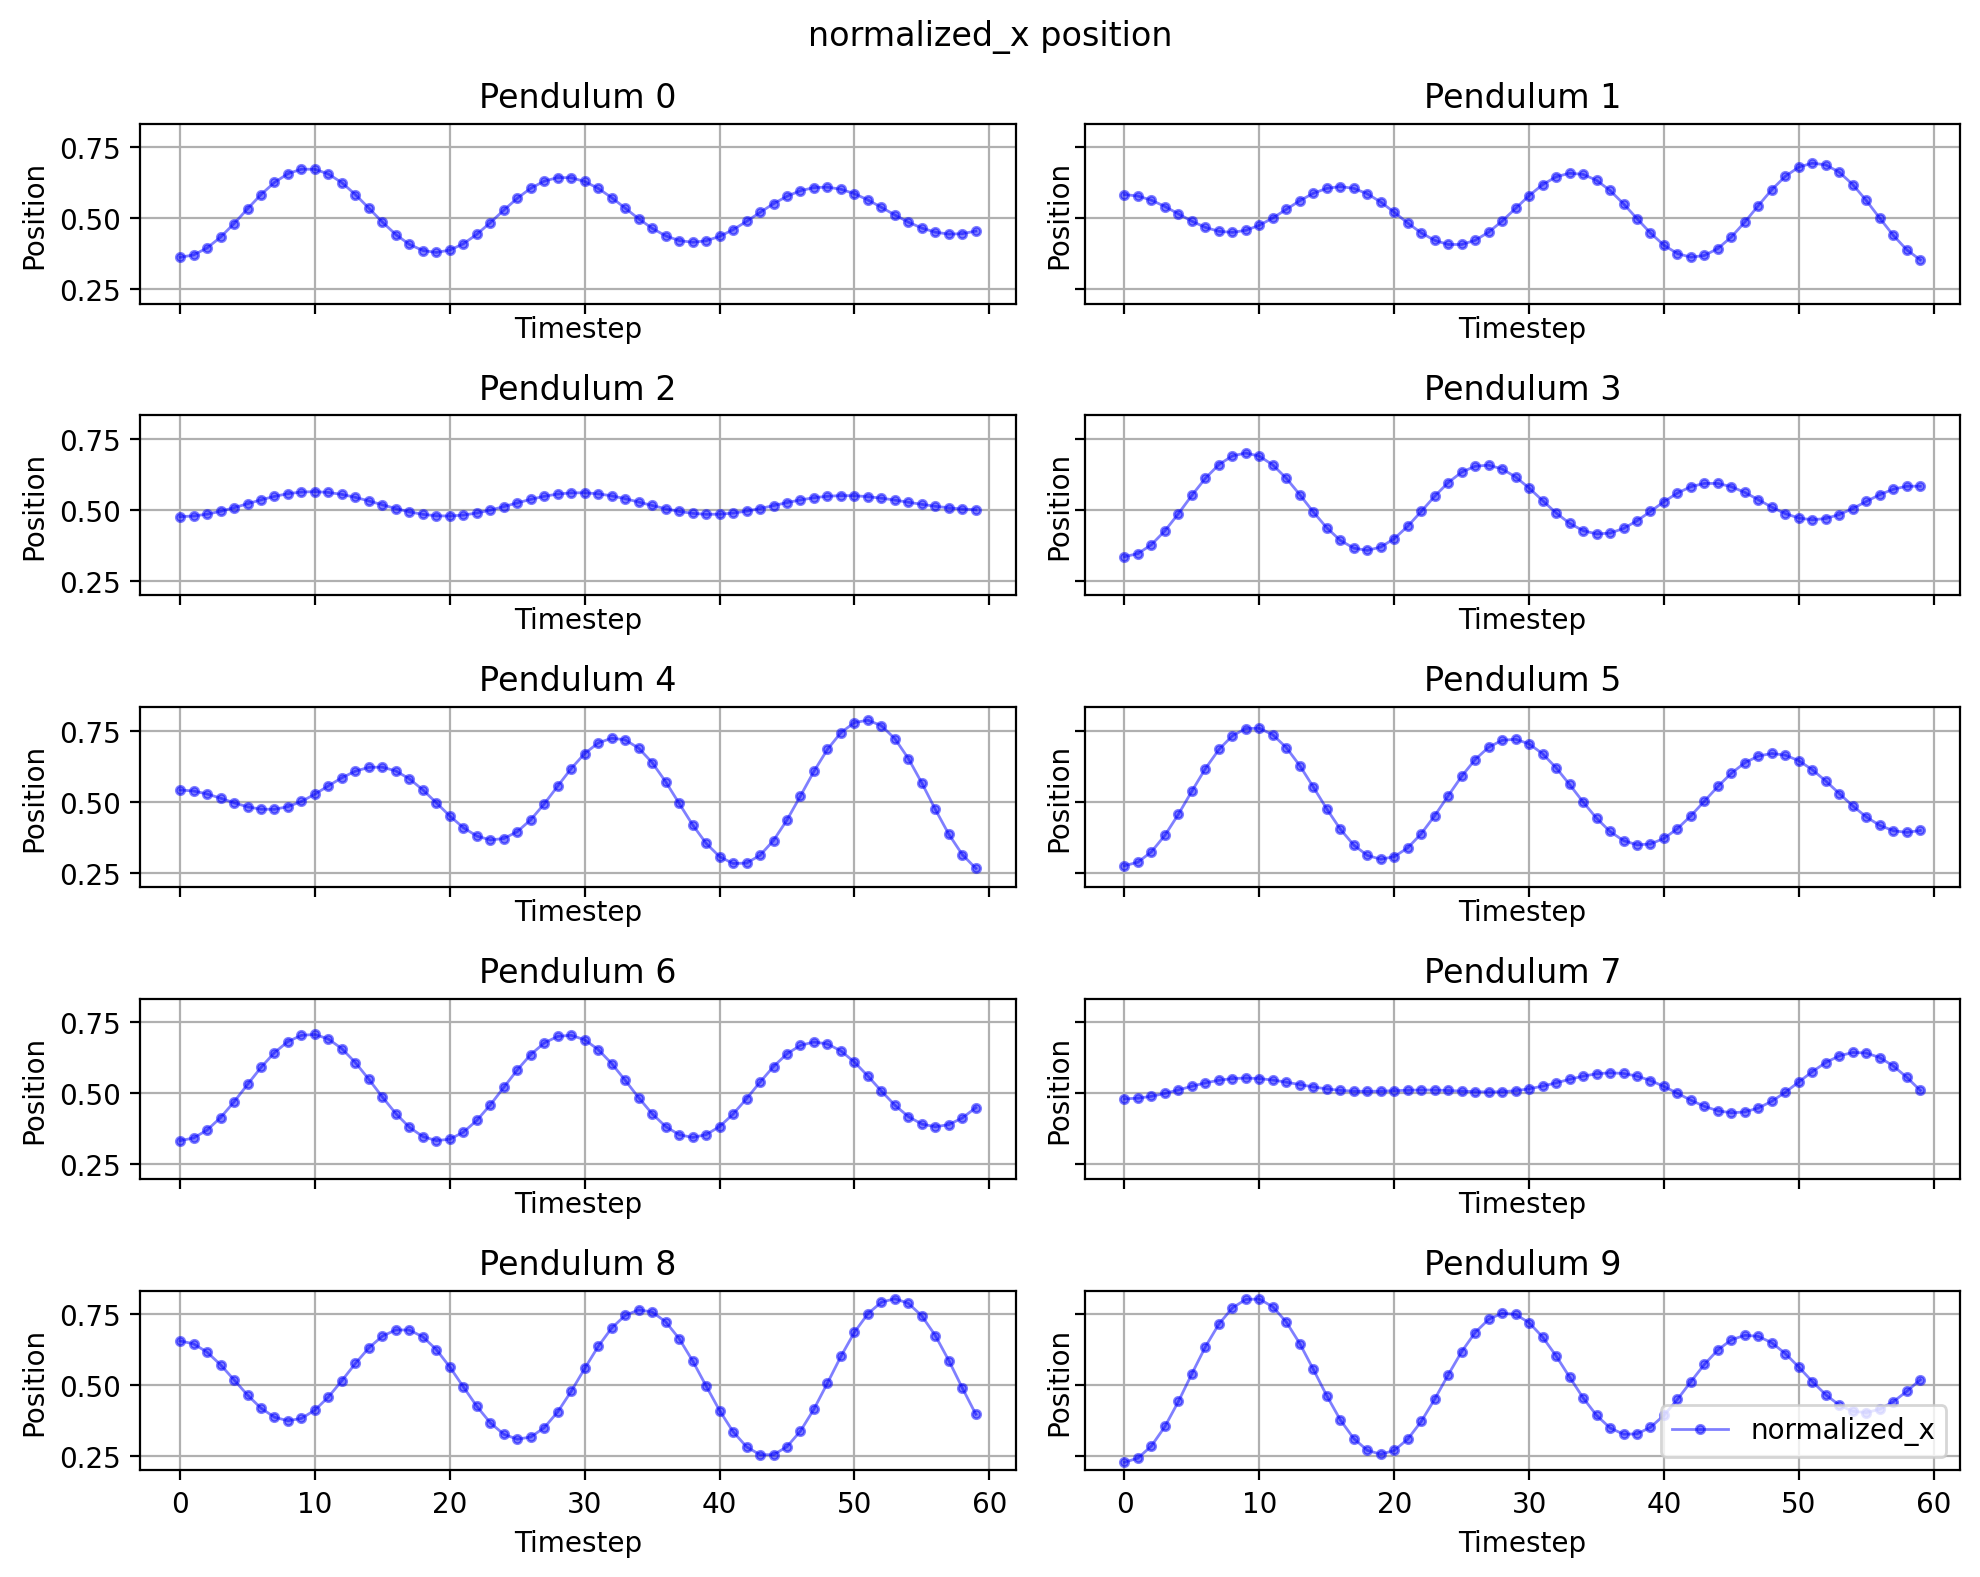

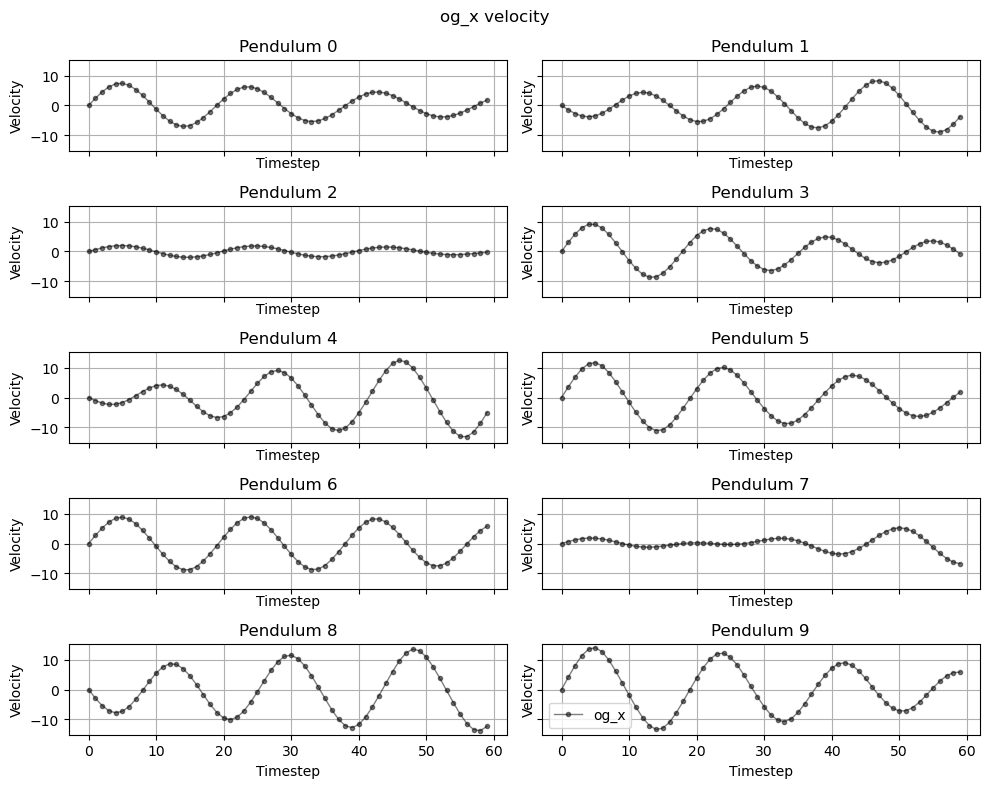

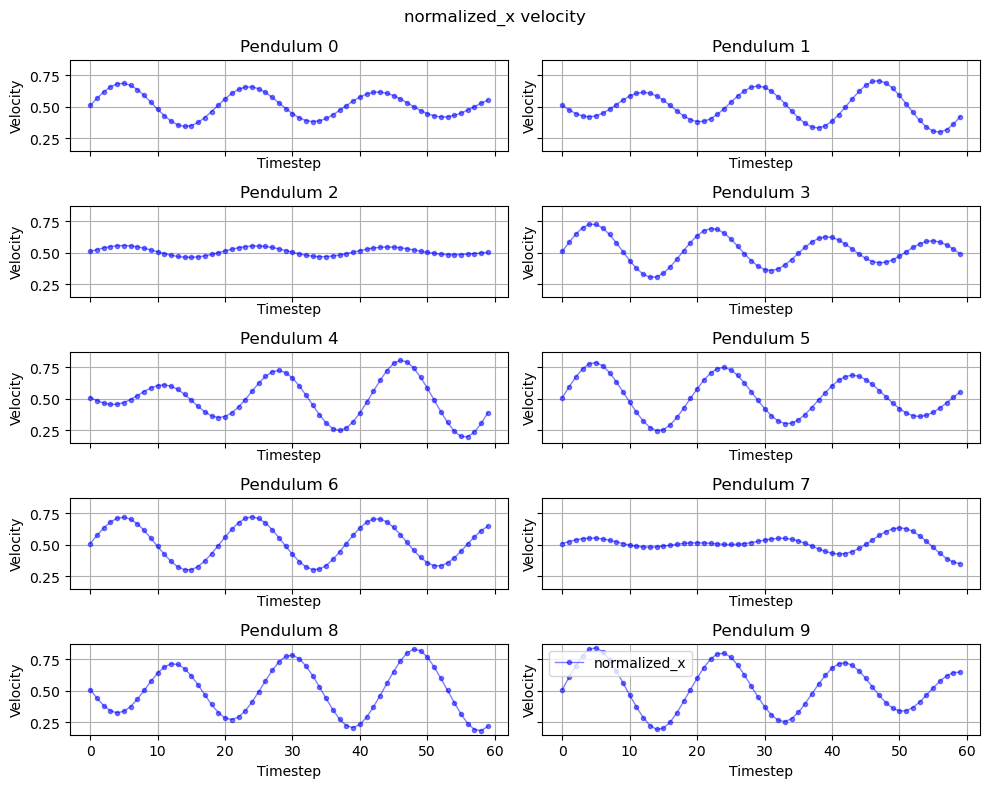

In [8]:
# 1. plot og_x position
fig, axs = plt.subplots(nrows = 5, ncols = 2, figsize = [10,8], dpi = 200, sharex=True, sharey=True)
for i_loop in range(10):
    i = i_loop * 2 # since we only want the position features
    plt.sca(axs.flatten()[i_loop])
    plt.plot(og_x[:,i], '.-', lw = 1, c = 'k', alpha = 0.5, label = 'og_x')
    plt.xlabel('Timestep')
    plt.ylabel('Position')
    plt.title(f'Pendulum {i_loop}')
    plt.grid()
fig.suptitle("og_x position")
plt.legend()
plt.tight_layout()
plt.show()

# 2. plot standardized_x position
fig, axs = plt.subplots(nrows = 5, ncols = 2, figsize = [10,8], dpi = 200, sharex=True, sharey=True)
for i_loop in range(10):
    i = i_loop * 2 # since we only want the position features
    plt.sca(axs.flatten()[i_loop])
    plt.plot(normalized_x[:,i], '.-', lw = 1, c = 'b', alpha = 0.5, label = 'normalized_x')
    plt.xlabel('Timestep')
    plt.ylabel('Position')
    plt.title(f'Pendulum {i_loop}')
    plt.grid()
fig.suptitle("normalized_x position")
plt.legend()
plt.tight_layout()
plt.show()

# 3. plot og_x velocity
fig, axs = plt.subplots(nrows = 5, ncols = 2, figsize = [10,8], dpi = 100, sharex=True, sharey=True)
for i_loop in range(10):
    i = i_loop * 2 + 1 # since we only want the velocity features
    plt.sca(axs.flatten()[i_loop])
    plt.plot(og_x[:,i], '.-', lw = 1, c = 'k', alpha = 0.5, label = 'og_x')
    plt.xlabel('Timestep')
    plt.ylabel('Velocity')
    plt.title(f'Pendulum {i_loop}')
    plt.grid()
fig.suptitle("og_x velocity")
plt.legend()
plt.tight_layout()
plt.show()

# 4. plot standardized_x velocity
fig, axs = plt.subplots(nrows = 5, ncols = 2, figsize = [10,8], dpi = 100, sharex=True, sharey=True)
for i_loop in range(10):
    i = i_loop * 2 + 1 # since we only want the velocity features
    plt.sca(axs.flatten()[i_loop])
    plt.plot(normalized_x[:,i], '.-', lw = 1, c = 'b', alpha = 0.5, label = 'normalized_x')
    plt.xlabel('Timestep')
    plt.ylabel('Velocity')
    plt.title(f'Pendulum {i_loop}')
    plt.grid()
fig.suptitle("normalized_x velocity")
plt.legend()
plt.tight_layout()
plt.show()

## Standardization

### Now we create function preproceess_data_standardize

In [64]:
def preproceess_data_standardize(NUM_DATA, sanity_check = False):
    global theta_Tr, theta_Te
    # 1. Load the data from npz file
    if not sanity_check:
        data = np.load('10pendula.npz')
    else:
        data = np.load('10pendula_sanity_check.npz')
    for key, val in data.items():
        exec(key + '=val')
    og_theta = data['theta']
    # below prints the evolution of the position (angle) over time of the 2nd pendulum in the 121st sample
    # plt.plot(og_theta[:, 111, 3, 0])
    
    # 2. preproceses data to the dimension we want
    # now, there are NUM_DATA data entry (i.e. initial conditions), 
    # each has 60 timesteps, and each timestep is a vector of size 20 
    # each feature: [p0, v0, p1, v1, ... p19, v19]
    theta = np.transpose(og_theta, (1, 0, 2, 3)).reshape(50000, 60, 20)
    theta = theta[:NUM_DATA, :, :]
    N, _, _ = theta.shape
    cutoff = int(np.ceil(0.7 * N))
    theta_Tr = theta[:cutoff, :, :]
    theta_Te = theta[cutoff: , :, :]
    
    # 3. standardize the data by viewing position and velocity as 2 features
    pos_tr = theta_Tr[:,:,::2]
    vel_tr = theta_Tr[:,:,1::2]
    
    mean_std_dict = {
        "mean_pos": np.mean(pos_tr),
        "std_pos": np.std(pos_tr),
        "mean_vel": np.mean(vel_tr),
        "std_vel": np.std(vel_tr)
    }
    
    theta_Tr[:,:,::2] = (theta_Tr[:,:,::2]  - mean_std_dict["mean_pos"]) / mean_std_dict["std_pos"] # position
    theta_Tr[:,:,1::2] = (theta_Tr[:,:,1::2]  - mean_std_dict["mean_vel"]) / mean_std_dict["std_vel"] # velocity
    
    theta_Te[:,:,::2] = (theta_Te[:,:,::2]  - mean_std_dict["mean_pos"]) / mean_std_dict["std_pos"] # position
    theta_Te[:,:,1::2] = (theta_Te[:,:,1::2]  - mean_std_dict["mean_vel"]) / mean_std_dict["std_vel"] # velocity
    
    return mean_std_dict

In [65]:
mean_std_dict = preproceess_data_standardize(NUM_DATA = 100, sanity_check = False)
best_model = train_transformer_teacher_forcing(EPOCH = 300)

Epoch: 0, Average training loss: 0.7567618024268381
Epoch: 30, Average training loss: 0.12373181892439011
Epoch: 60, Average training loss: 0.08656885742947436
Epoch: 90, Average training loss: 0.07938076850599285
Epoch: 120, Average training loss: 0.05404242966774779
Epoch: 150, Average training loss: 0.04777119571423881
Epoch: 180, Average training loss: 0.04586539572276167
Epoch: 210, Average training loss: 0.04713939035395446
Epoch: 240, Average training loss: 0.04307189788258351
Epoch: 270, Average training loss: 0.043938651248483625
Epoch: 300, Average training loss: 0.04407478543703628


average loss is: 0.14410737444990585
Visualizing test with loss: 0.5598668509591737


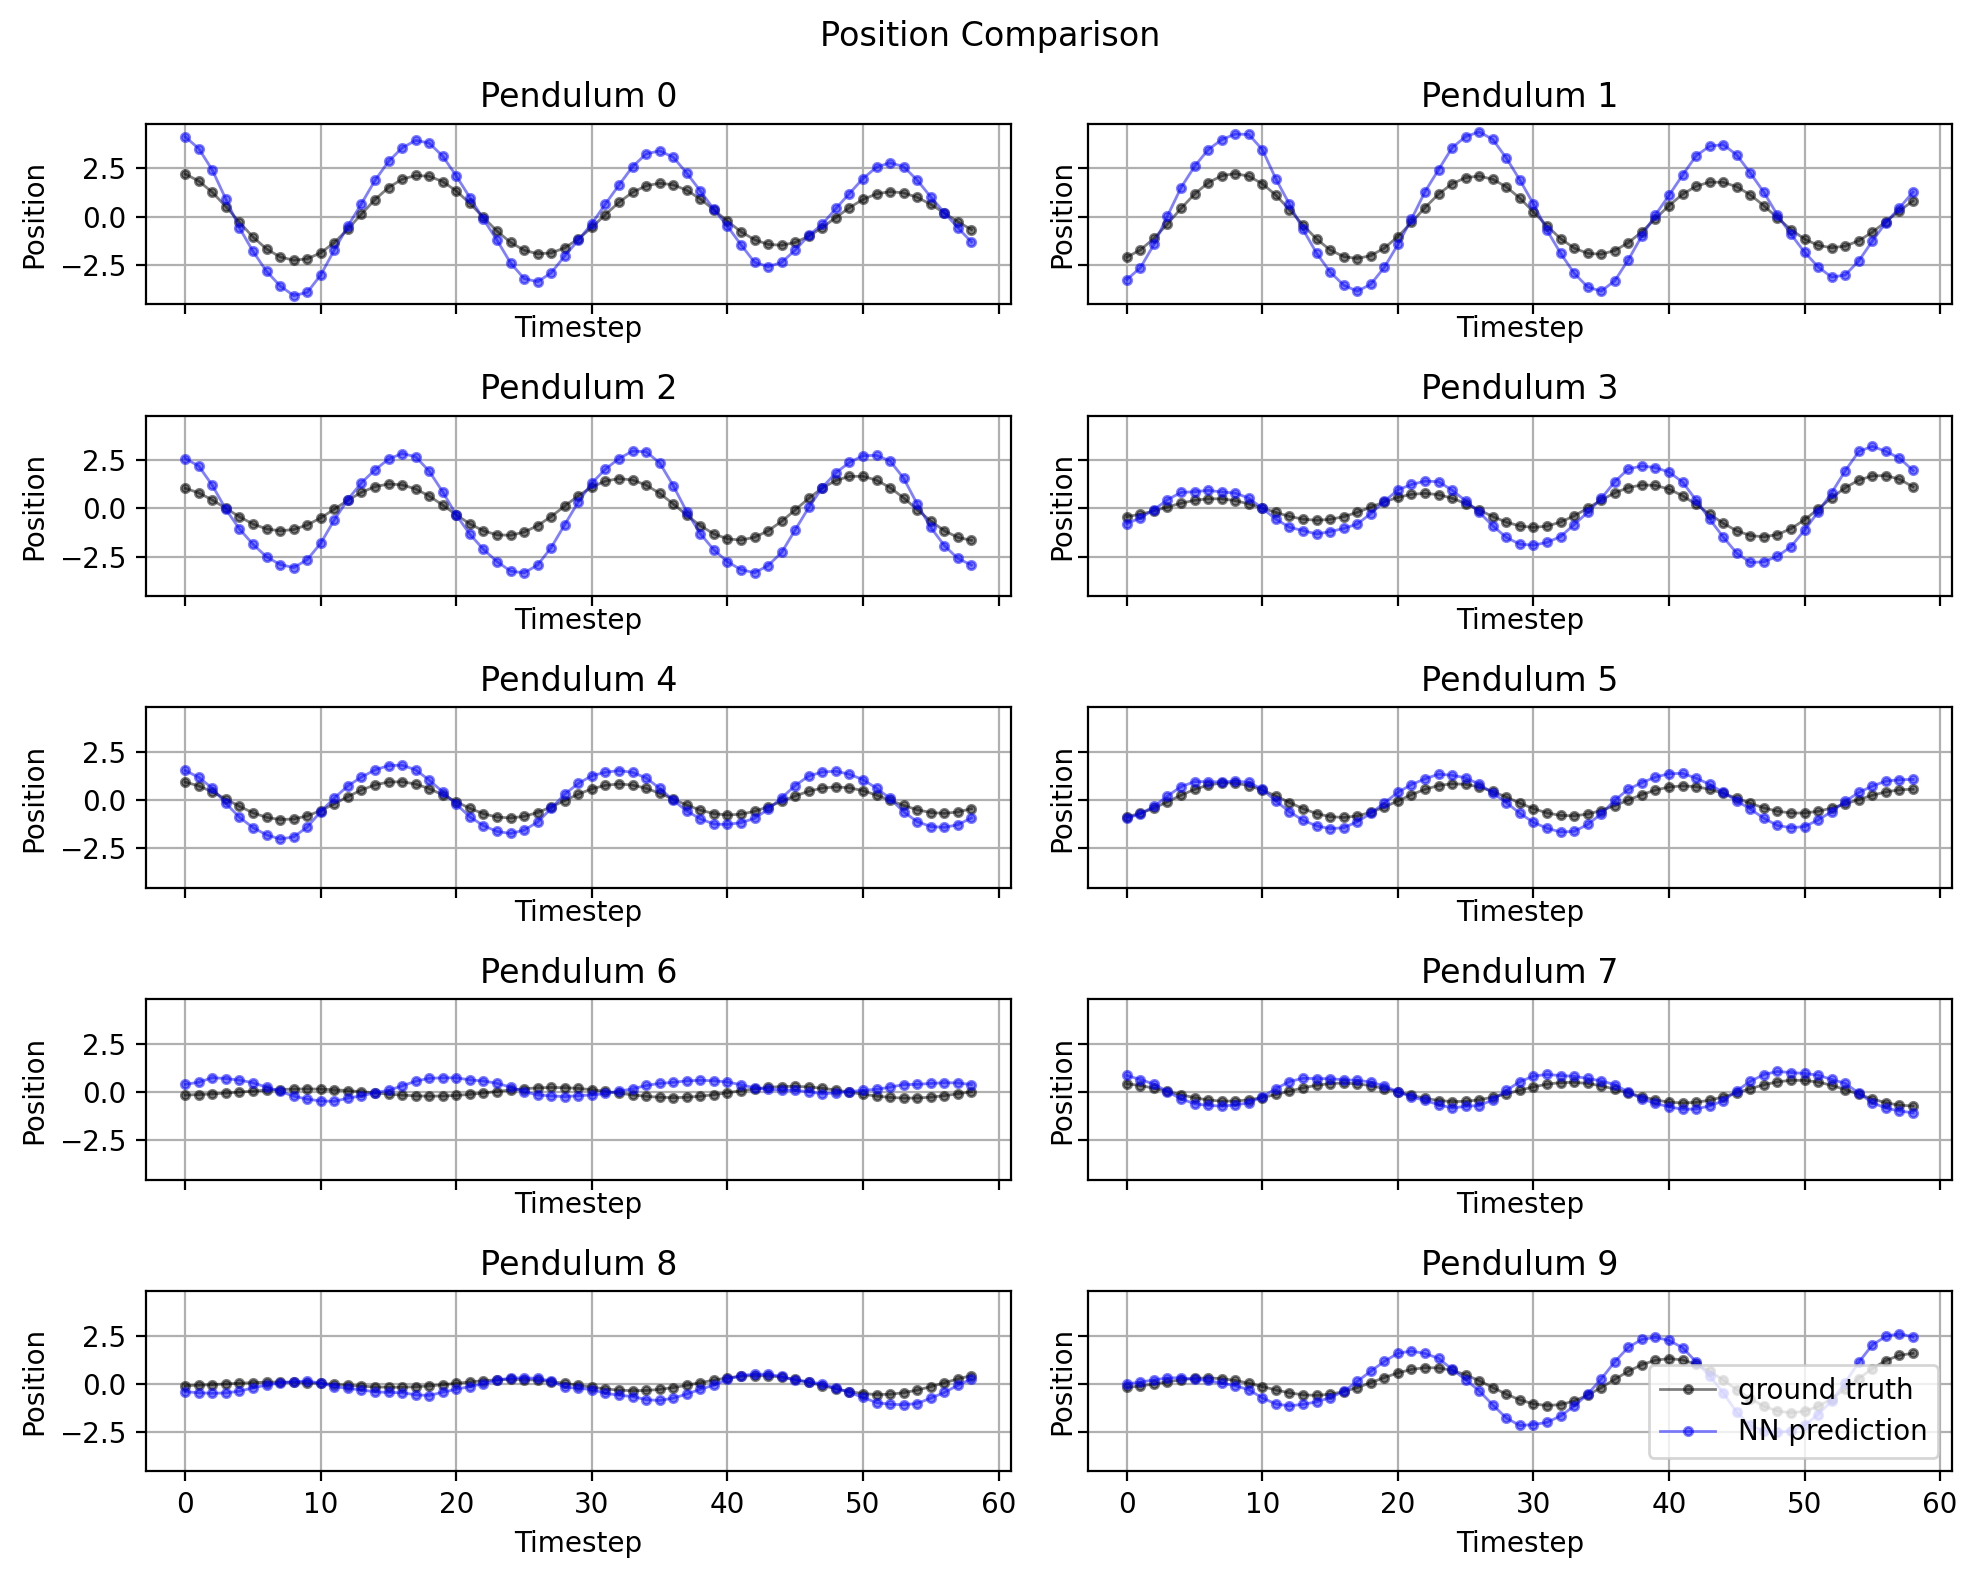

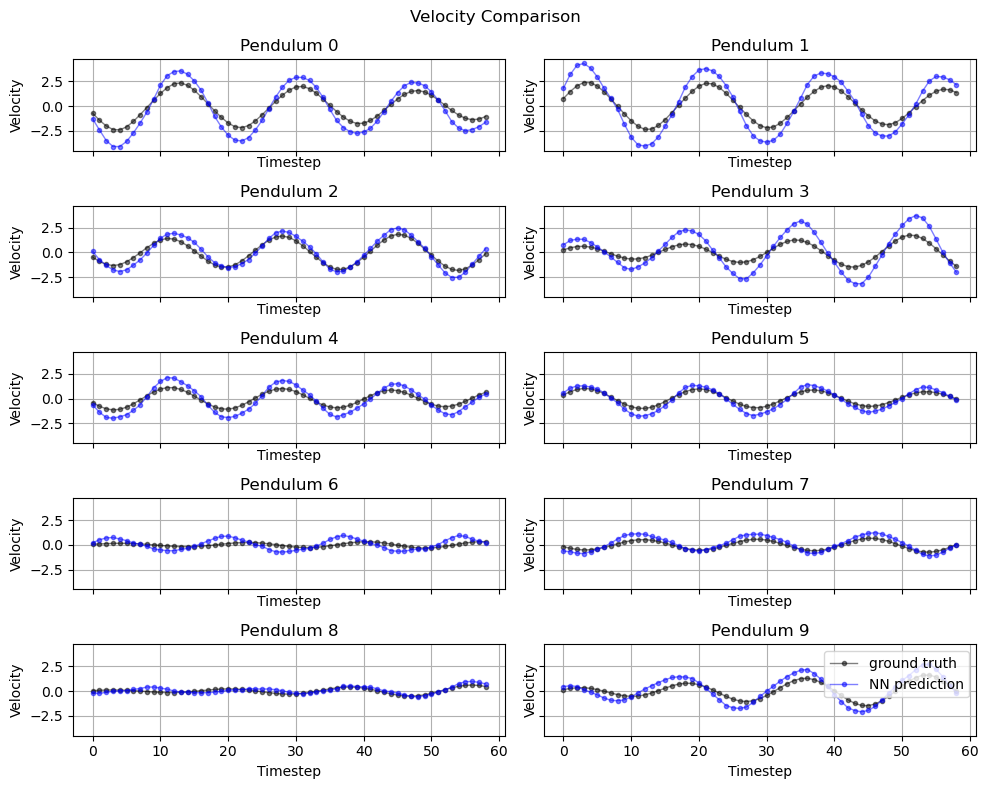

In [68]:
average_testing_loss, loss_list = inference_cheat()

print("average loss is: " + str(average_testing_loss))
visualize_test(loss_list, average_testing_loss, want_worst = True, want_avg = False)

average loss is: 1.4925040333371002


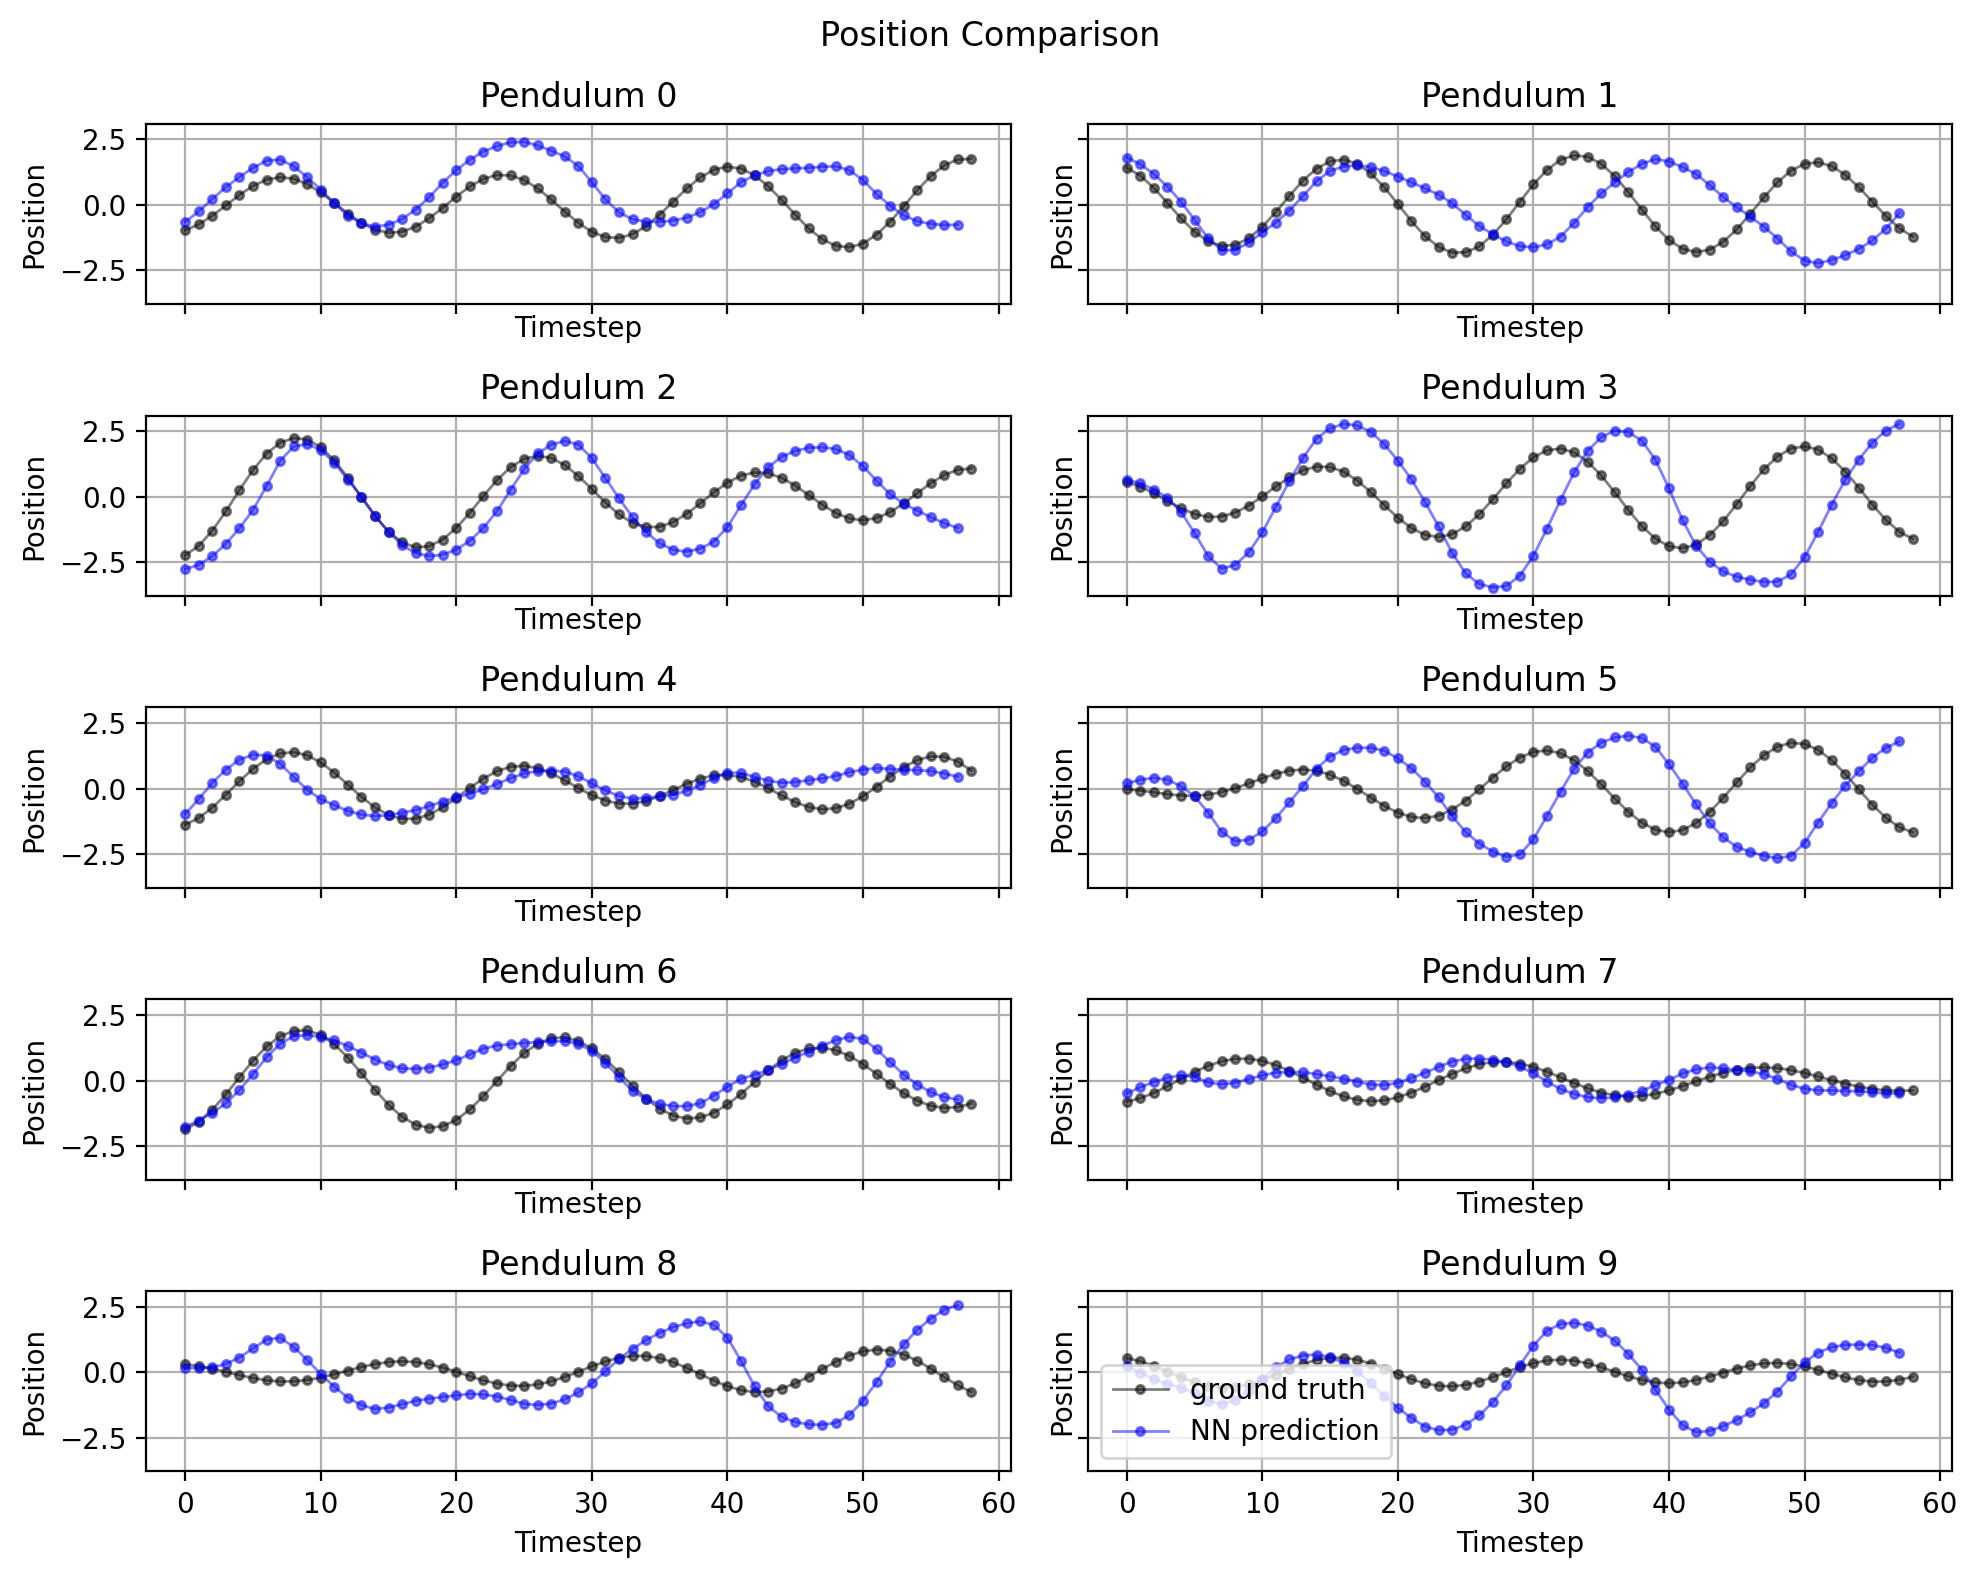

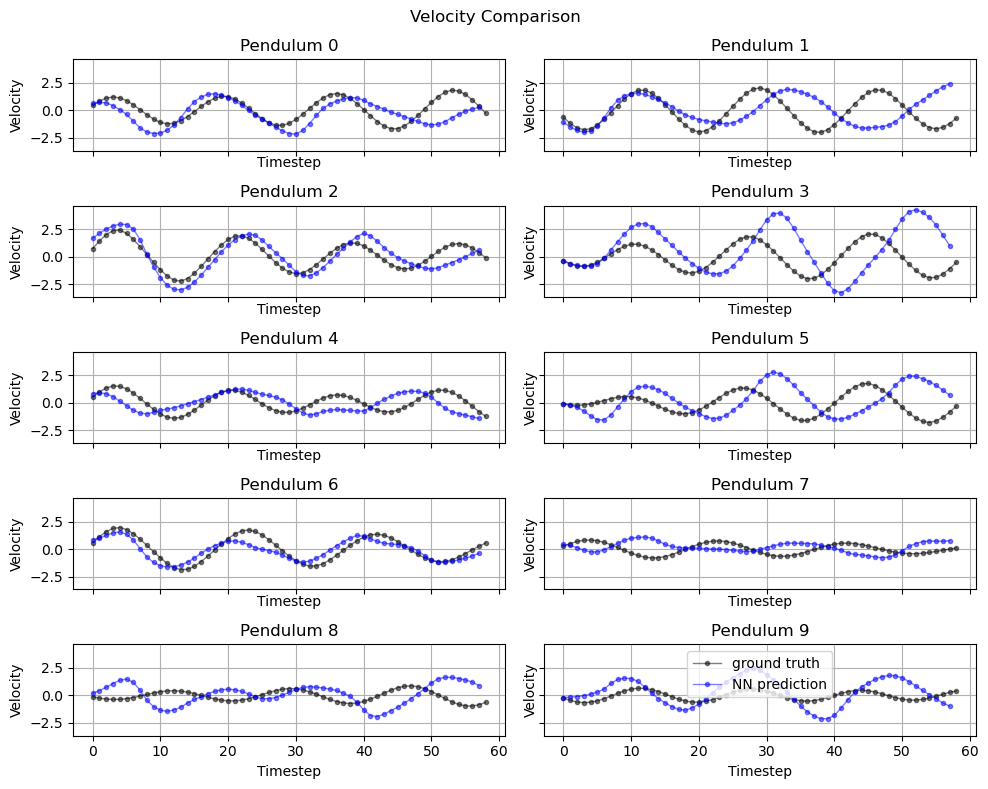

In [69]:
average_testing_loss, worst_dict = inference_one_input()
print("average loss is: {}".format(average_testing_loss))
visualize_worst_test(worst_dict)

## Normalization

In [9]:
def preproceess_data_normalize(NUM_DATA, sanity_check = False):
    global theta_Tr, theta_Te
    # 1. Load the data from npz file
    if not sanity_check:
        data = np.load('10pendula.npz')
    else:
        data = np.load('10pendula_sanity_check.npz')
    for key, val in data.items():
        exec(key + '=val')
    og_theta = data['theta']
    # below prints the evolution of the position (angle) over time of the 2nd pendulum in the 121st sample
    # plt.plot(og_theta[:, 111, 3, 0])
    
    # 2. preproceses data to the dimension we want
    # now, there are NUM_DATA data entry (i.e. initial conditions), 
    # each has 60 timesteps, and each timestep is a vector of size 20 
    # each feature: [p0, v0, p1, v1, ... p19, v19]
    theta = np.transpose(og_theta, (1, 0, 2, 3)).reshape(50000, 60, 20)
    theta = theta[:NUM_DATA, :, :]
    N, _, _ = theta.shape
    cutoff = int(np.ceil(0.7 * N))
    theta_Tr = theta[:cutoff, :, :]
    theta_Te = theta[cutoff: , :, :]
    
    # 3. NORMALIZE the data by viewing position and velocity as 2 features
    pos_tr = theta_Tr[:,:,::2]
    vel_tr = theta_Tr[:,:,1::2]
    
    min_max_dict = {
        "min_pos": np.min(pos_tr),
        "max_pos": np.max(pos_tr),
        "min_vel": np.min(vel_tr),
        "max_vel": np.max(vel_tr)
    }
    
    theta_Tr[:,:,::2] = (theta_Tr[:,:,::2]  - min_max_dict["min_pos"]) / (min_max_dict["max_pos"] - min_max_dict["min_pos"]) # position
    theta_Tr[:,:,1::2] = (theta_Tr[:,:,1::2]  - min_max_dict["min_vel"]) / (min_max_dict["max_vel"] - min_max_dict["min_vel"]) # velocity
    
    theta_Te[:,:,::2] = (theta_Te[:,:,::2]  - min_max_dict["min_pos"]) / (min_max_dict["max_pos"] - min_max_dict["min_pos"]) # position
    theta_Te[:,:,1::2] = (theta_Te[:,:,1::2]  - min_max_dict["min_vel"]) / (min_max_dict["max_vel"] - min_max_dict["min_vel"]) # velocity
    
    return min_max_dict

In [11]:
min_max_dict = preproceess_data_normalize(NUM_DATA = 100, sanity_check = False)
best_model = train_transformer_teacher_forcing(EPOCH = 300)

Epoch: 0, Average training loss: 0.04262419674633523
Epoch: 30, Average training loss: 0.0023642495421661094
Epoch: 60, Average training loss: 0.0019726803612242832
Epoch: 90, Average training loss: 0.0016682927139313492
Epoch: 120, Average training loss: 0.0017045084249185955
Epoch: 150, Average training loss: 0.0018609273705076518
Epoch: 180, Average training loss: 0.0014652945571325302
Epoch: 210, Average training loss: 0.001473052912102228
Epoch: 240, Average training loss: 0.0012578095346006911
Epoch: 270, Average training loss: 0.0015001293307802396
Epoch: 300, Average training loss: 0.0012306462717278672


average loss is: 0.003468933562894272
Visualizing test with loss: 0.006817242096522711


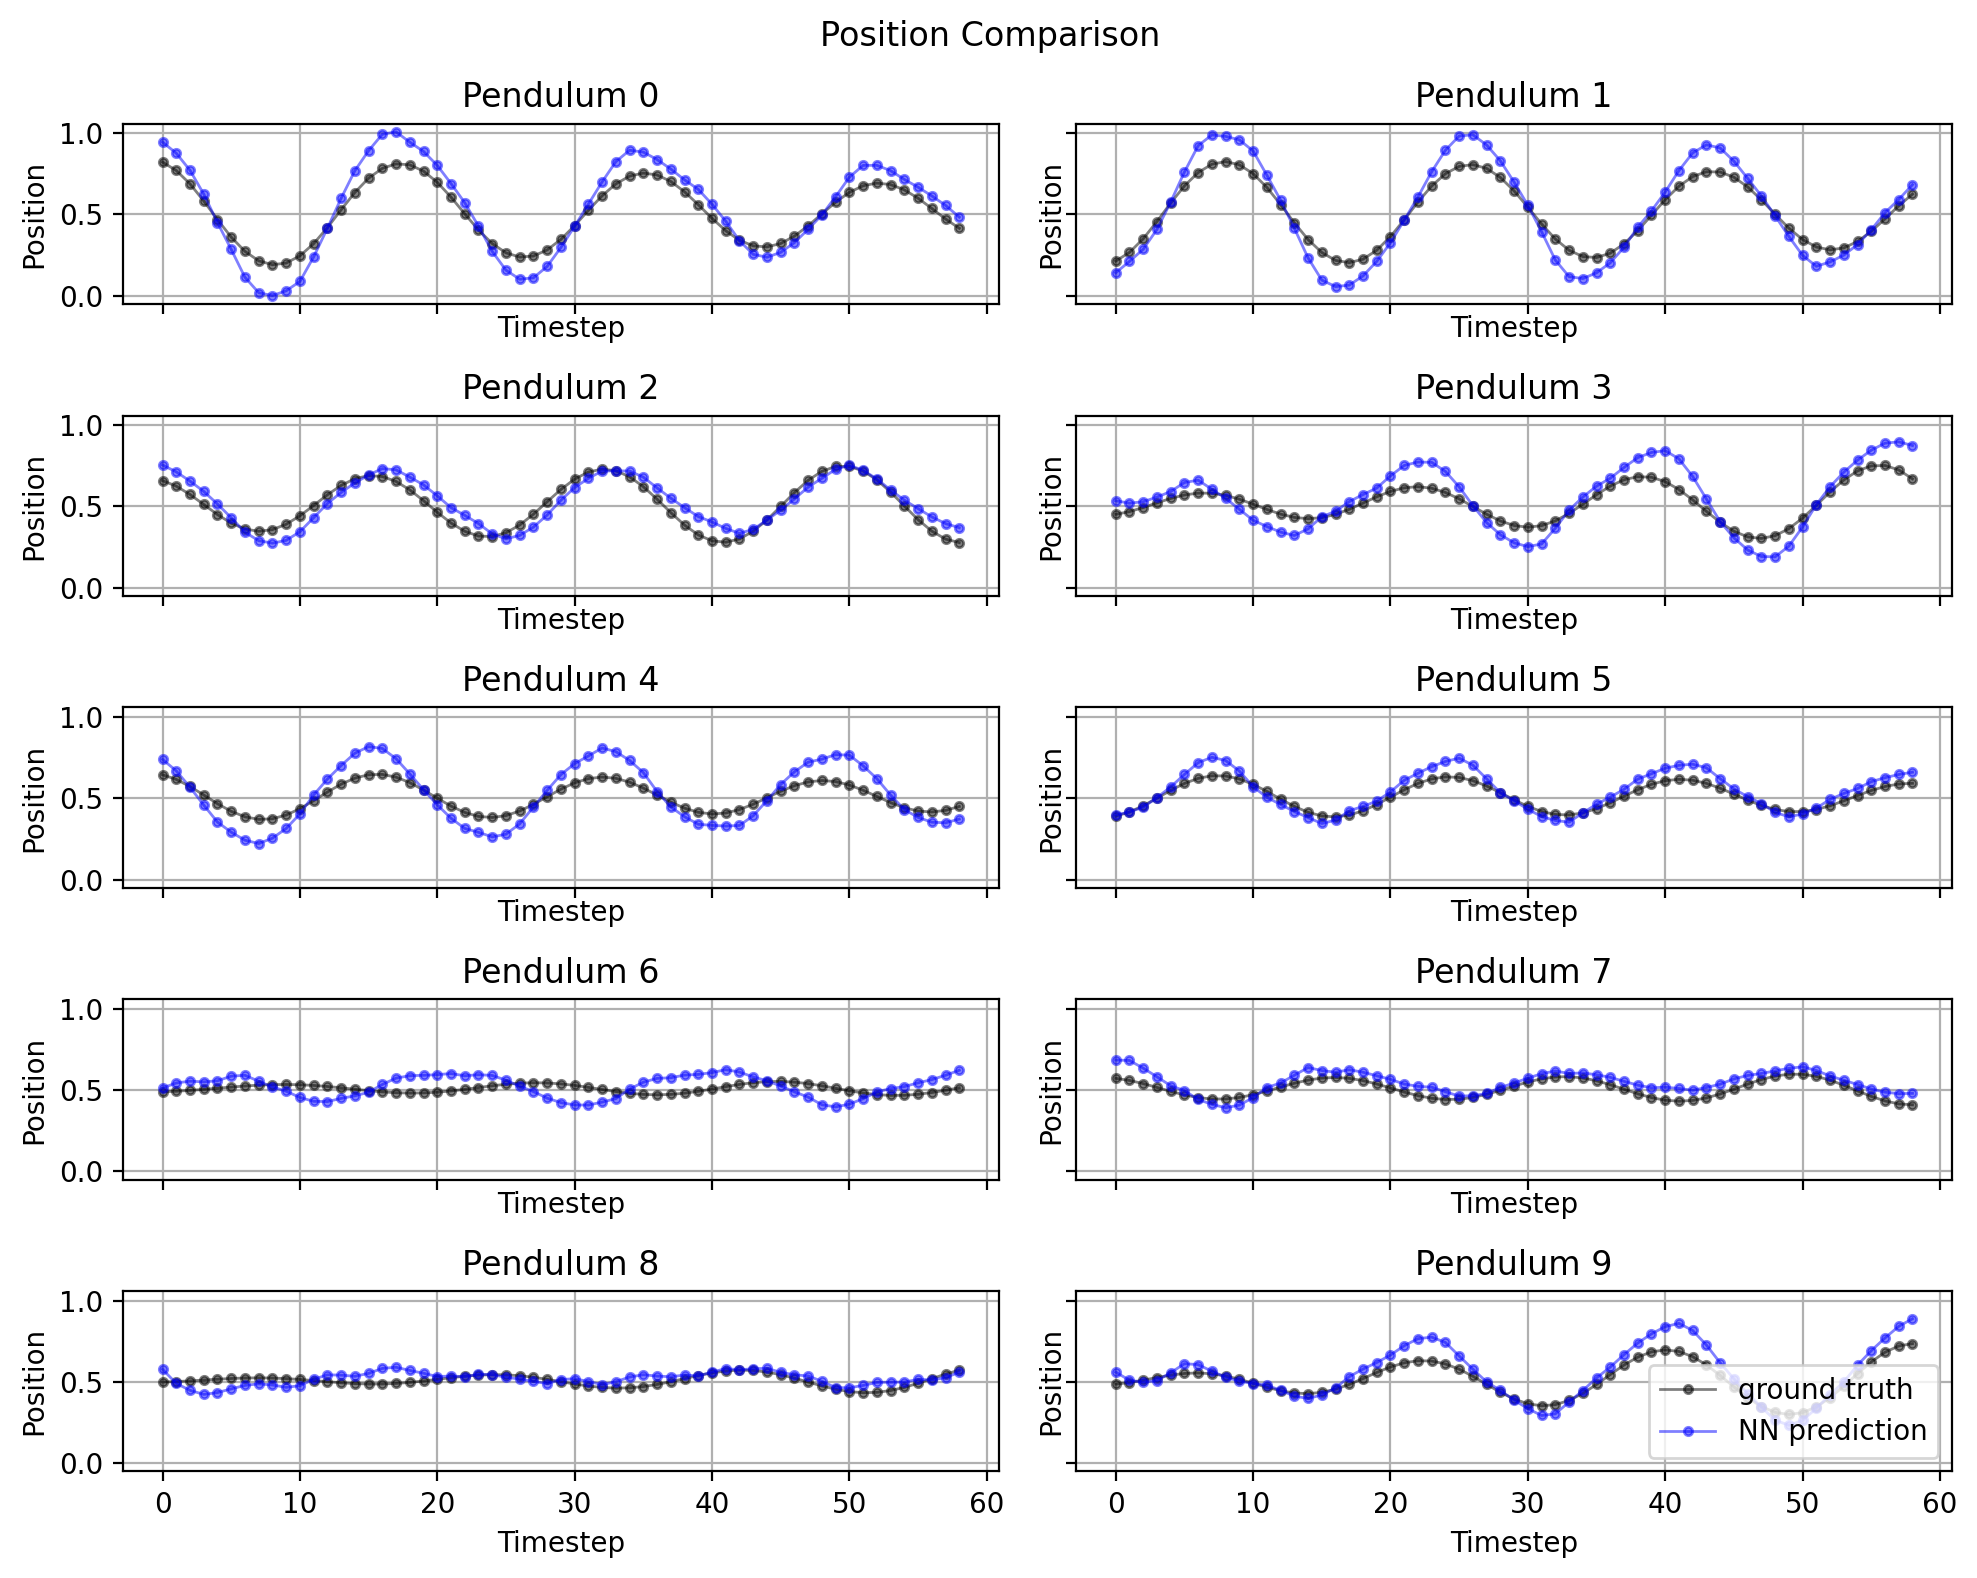

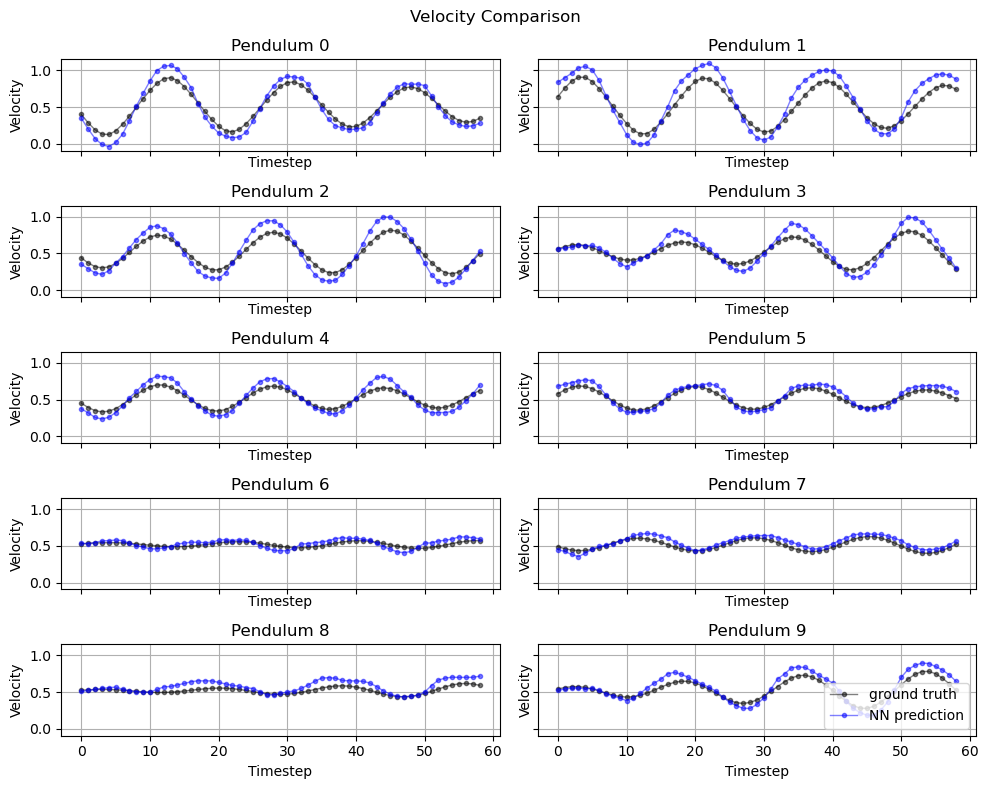

In [12]:
average_testing_loss, loss_list = inference_cheat()

print("average loss is: " + str(average_testing_loss))
visualize_test(loss_list, average_testing_loss, want_worst = True, want_avg = False)

average loss is: 0.03283144684564034


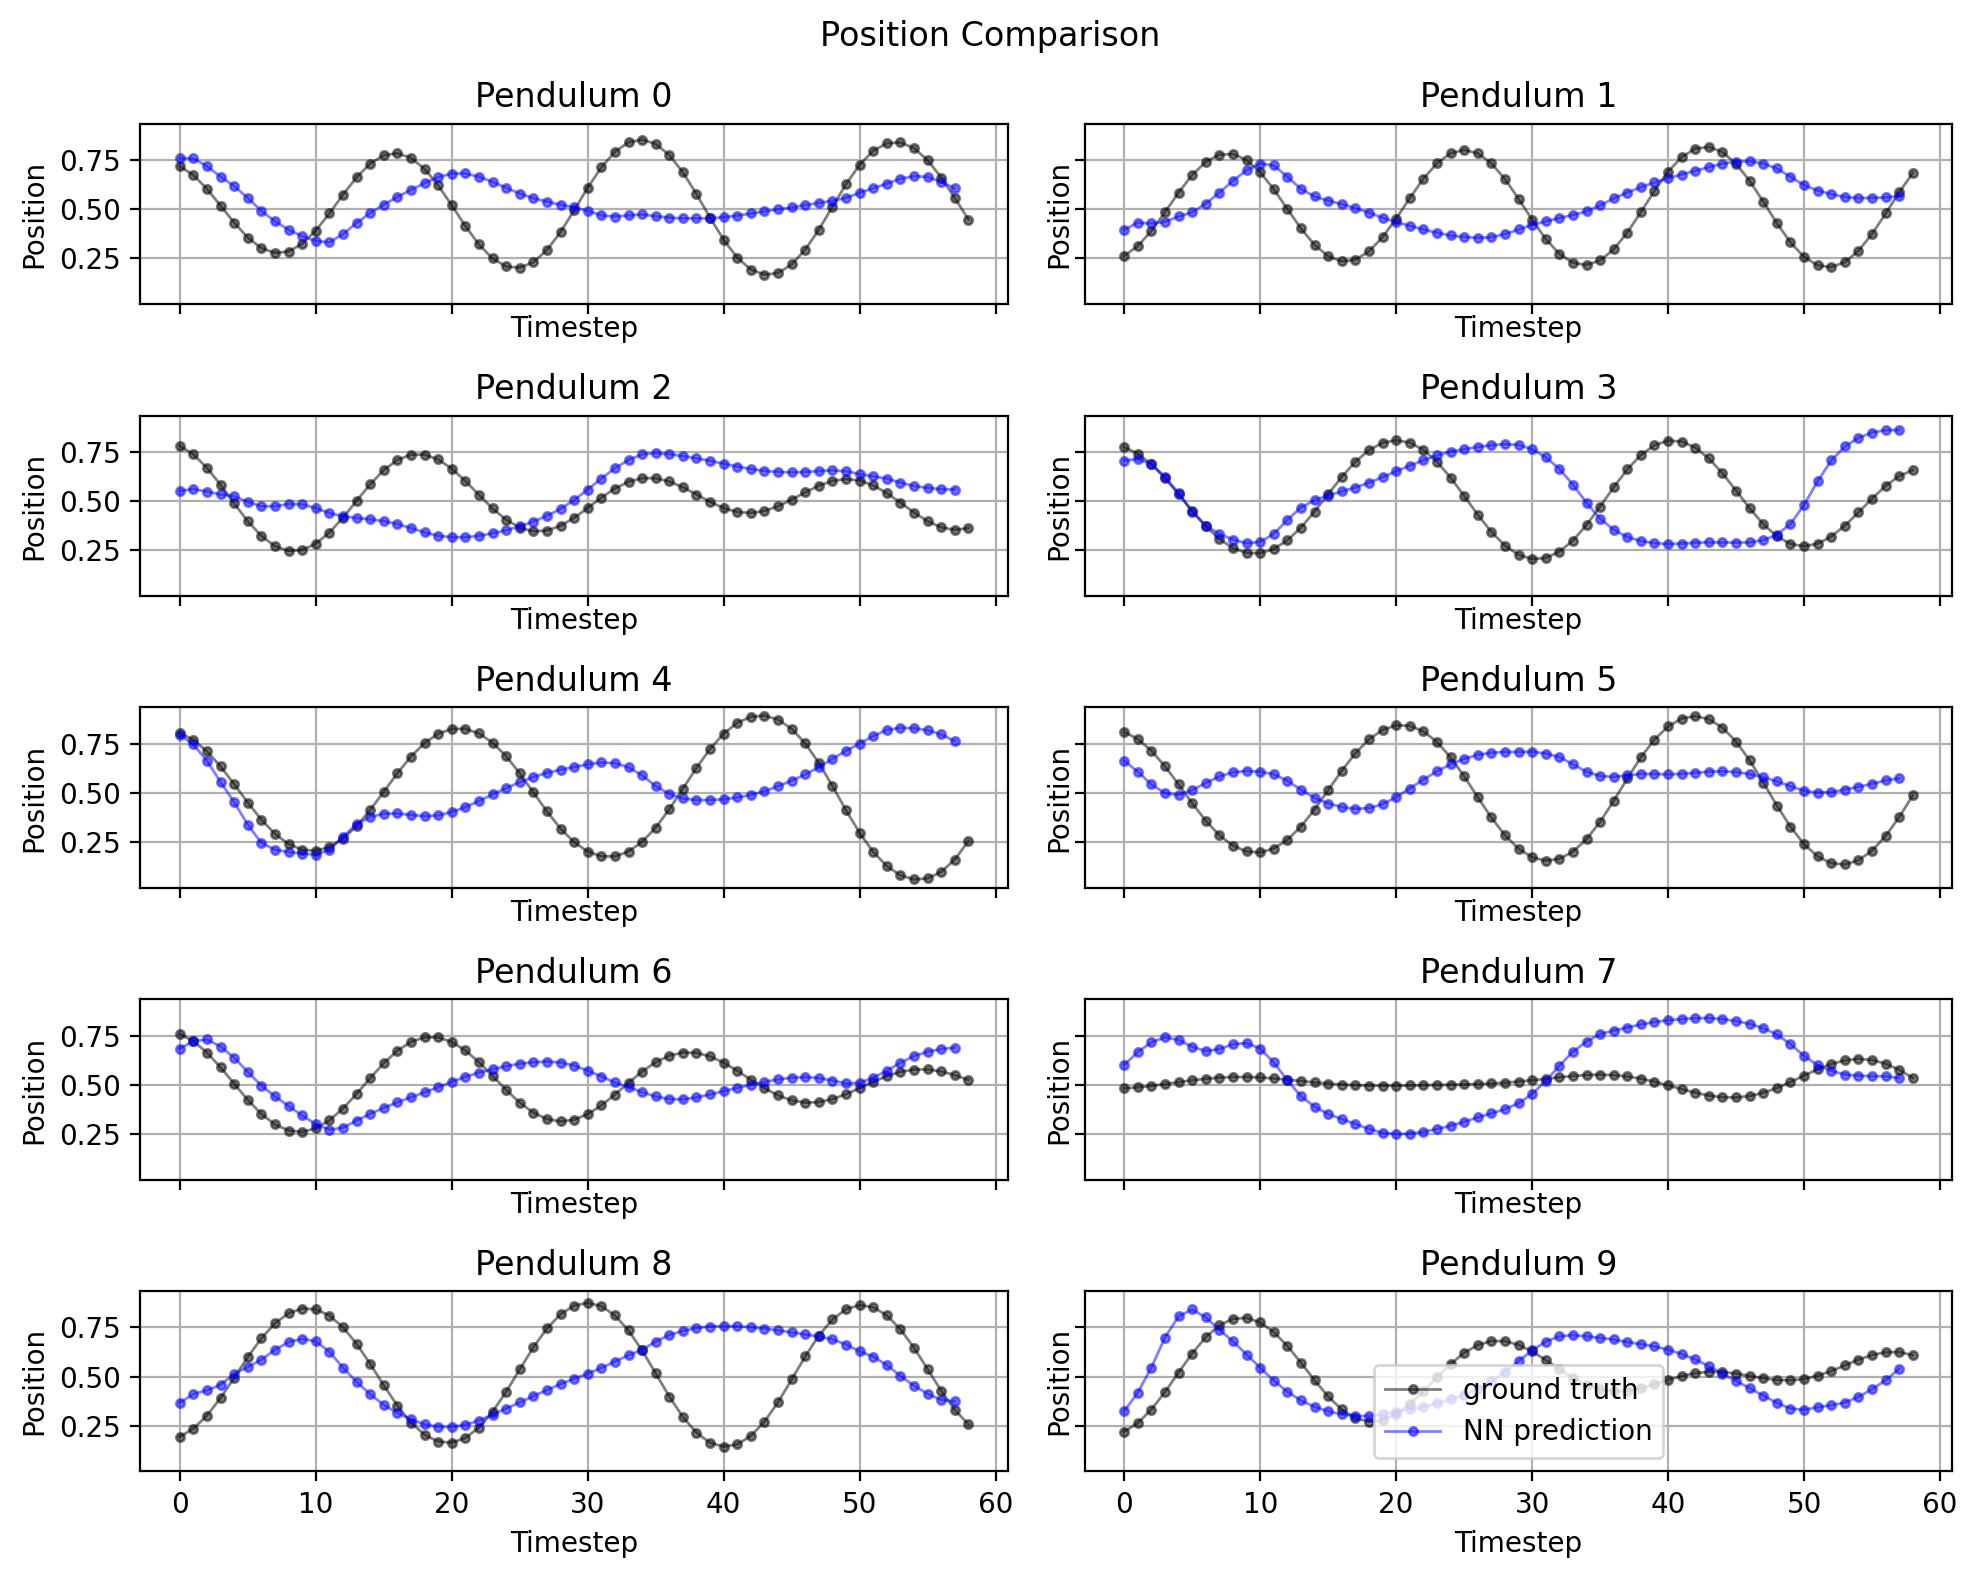

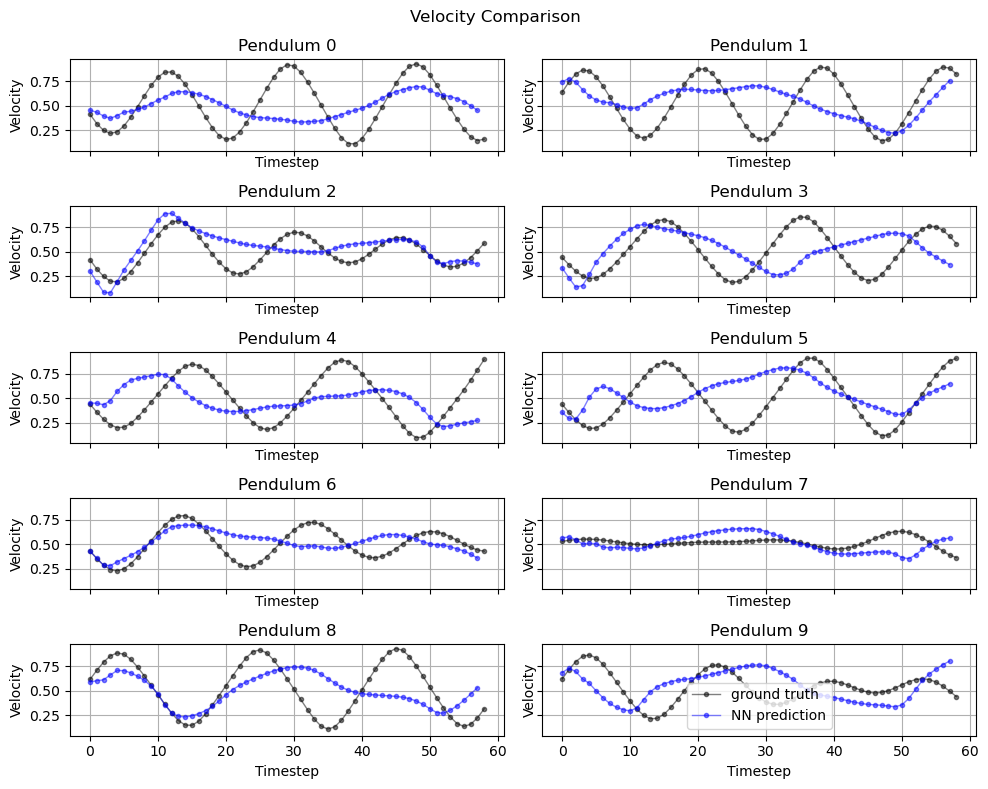

In [13]:
average_testing_loss, worst_dict = inference_one_input()
print("average loss is: {}".format(average_testing_loss))
visualize_worst_test(worst_dict)